In [1]:
import mlflow

# Set the experiment name
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Car_Price_Regression_Experiments")

/Users/saugatshakya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<Experiment: artifact_location='mlflow-artifacts:/839360960728144798', creation_time=1757748339823, experiment_id='839360960728144798', last_update_time=1757748339823, lifecycle_stage='active', name='Car_Price_Regression_Experiments', tags={}>

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
data = pd.read_csv("cars.csv")
print("Dataset loaded successfully!")
print(f"Original dataset shape: {data.shape}")

Dataset loaded successfully!
Original dataset shape: (8128, 13)


In [4]:
# Display basic information about the dataset
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [5]:
# Display first few rows
print("\nFirst 5 rows:")
data.head()


First 5 rows:


name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2     12.7@ 2,700(kgm@ rpm)    5.0  
3  22.4 kgm at 1750-2750rpm    5.0  
4     11.5@ 4,500(kgm@ rpm)    5.0

In [6]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64


In [7]:
# Check for duplicates
print(f"\nNumber of duplicates: {data.duplicated().sum()}")


Number of duplicates: 1202


In [8]:
# Remove duplicates
data = data.drop_duplicates()
print(f"Dataset shape after removing duplicates: {data.shape}")

Dataset shape after removing duplicates: (6926, 13)


In [9]:
# Remove CNG and LPG fuel types as instructed
data = data[~data['fuel'].isin(['CNG', 'LPG'])]
print(f"Dataset shape after removing CNG/LPG: {data.shape}")

Dataset shape after removing CNG/LPG: (6832, 13)


In [10]:
# Clean mileage column
data['mileage'] = (
    data['mileage']
    .str.replace('kmpl', '', regex=False)
    .str.replace('km/kg', '', regex=False)
    .str.strip()
)
data['mileage'] = pd.to_numeric(data['mileage'], errors='coerce')

In [11]:
# Clean engine column
data['engine'] = (
    data['engine']
    .str.replace('CC', '', regex=False)
    .str.strip()
)
data['engine'] = pd.to_numeric(data['engine'], errors='coerce')


In [12]:
# Clean max_power column
data['max_power'] = (
    data['max_power']
    .str.replace('bhp', '', regex=False)
    .str.strip()
)
data['max_power'] = pd.to_numeric(data['max_power'], errors='coerce')

In [13]:
# Fill missing values in seats with mode
data['seats'] = data['seats'].fillna(data['seats'].mode()[0])

In [14]:
# Fill other missing values with median
for col in ['mileage', 'engine', 'max_power']:
    data[col] = data[col].fillna(data[col].median())

In [15]:
# Drop torque column as instructed
data.drop(columns=['torque'], inplace=True)

In [16]:
# Map owner values as instructed
owner_map = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
data['owner'] = data['owner'].map(owner_map)

In [17]:
# Remove test drive cars as instructed
data = data[data['owner'] != 5]
print(f"Dataset shape after removing test drive cars: {data.shape}")

Dataset shape after removing test drive cars: (6827, 12)


In [18]:
# Extract brand from name
data['brand'] = data['name'].str.split().str[0]
data['brand'] = data['brand'].fillna('Unknown')
data.drop(columns=['name'], inplace=True)

In [19]:
#see all brand column unique values
print("\nUnique brands in the dataset:")
print(data['brand'].unique())


Unique brands in the dataset:
['Maruti' 'Skoda' 'Honda' 'Hyundai' 'Toyota' 'Ford' 'Renault' 'Mahindra'
 'Tata' 'Chevrolet' 'Fiat' 'Datsun' 'Jeep' 'Mercedes-Benz' 'Mitsubishi'
 'Audi' 'Volkswagen' 'BMW' 'Nissan' 'Lexus' 'Jaguar' 'Land' 'MG' 'Volvo'
 'Daewoo' 'Kia' 'Force' 'Ambassador' 'Ashok' 'Isuzu' 'Opel' 'Peugeot']


In [20]:
# Apply log transformation to selling price as instructed
data['selling_price'] = np.log(data['selling_price'])

In [21]:
# Display final dataset info
print("\nFinal dataset info:")
data.info()


Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 6827 entries, 0 to 8125
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           6827 non-null   int64  
 1   selling_price  6827 non-null   float64
 2   km_driven      6827 non-null   int64  
 3   fuel           6827 non-null   object 
 4   seller_type    6827 non-null   object 
 5   transmission   6827 non-null   object 
 6   owner          6827 non-null   int64  
 7   mileage        6827 non-null   float64
 8   engine         6827 non-null   float64
 9   max_power      6827 non-null   float64
 10  seats          6827 non-null   float64
 11  brand          6827 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 693.4+ KB


In [22]:
print("\nFirst 5 rows of cleaned data:")
data.head()


First 5 rows of cleaned data:


year  selling_price  km_driven    fuel seller_type transmission  owner  \
0  2014      13.017003     145500  Diesel  Individual       Manual      1   
1  2014      12.821258     120000  Diesel  Individual       Manual      2   
2  2006      11.970350     140000  Petrol  Individual       Manual      3   
3  2010      12.323856     127000  Diesel  Individual       Manual      1   
4  2007      11.775290     120000  Petrol  Individual       Manual      1   

   mileage  engine  max_power  seats    brand  
0    23.40  1248.0      74.00    5.0   Maruti  
1    21.14  1498.0     103.52    5.0    Skoda  
2    17.70  1497.0      78.00    5.0    Honda  
3    23.00  1396.0      90.00    5.0  Hyundai  
4    16.10  1298.0      88.20    5.0   Maruti

In [23]:
# Check for remaining missing values
print("\nRemaining missing values:")
print(data.isnull().sum())


Remaining missing values:
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
seats            0
brand            0
dtype: int64


In [24]:
# Set style for plots
plt.style.use('ggplot')
sns.set_palette("husl")

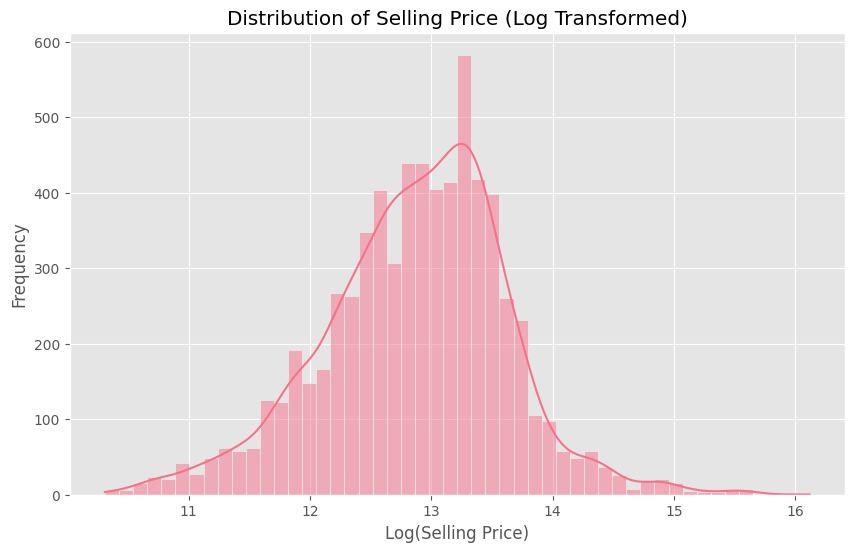

In [25]:
# Visualize the distribution of selling price (log transformed)
plt.figure(figsize=(10, 6))
sns.histplot(data['selling_price'], bins=50, kde=True)
plt.title("Distribution of Selling Price (Log Transformed)")
plt.xlabel("Log(Selling Price)")
plt.ylabel("Frequency")
plt.show()

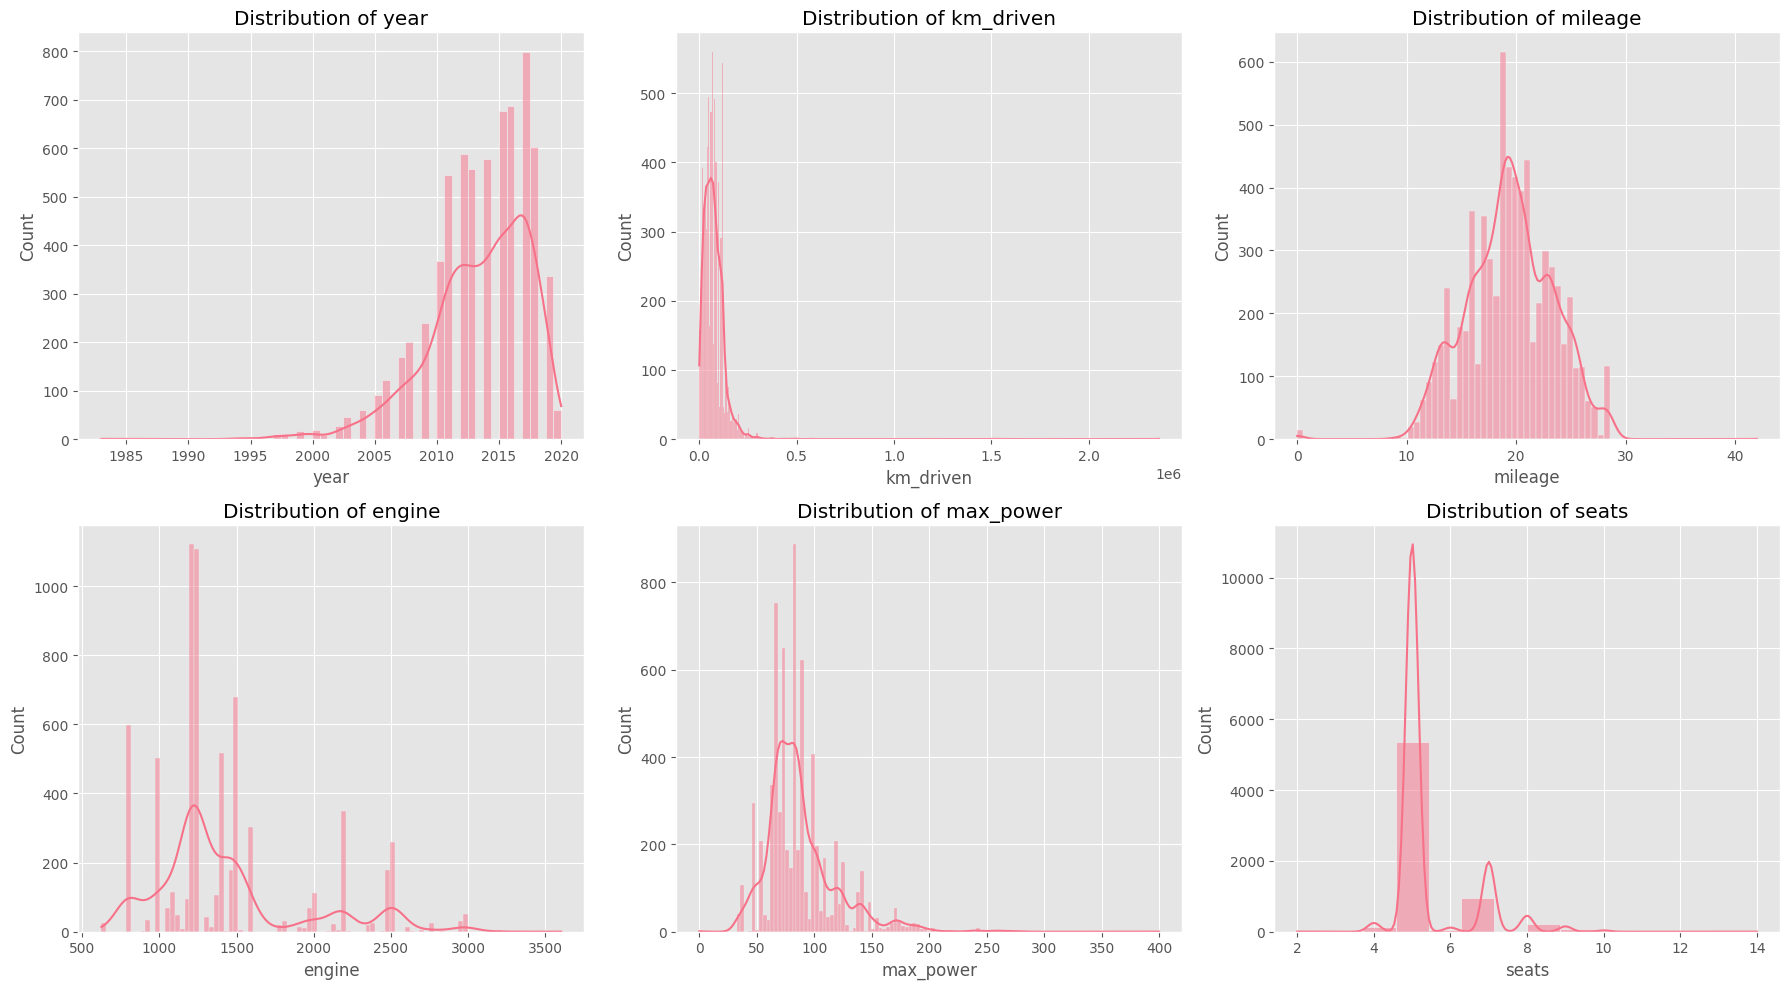

In [26]:
# Visualize numerical features
num_cols = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    
plt.tight_layout()
plt.show()

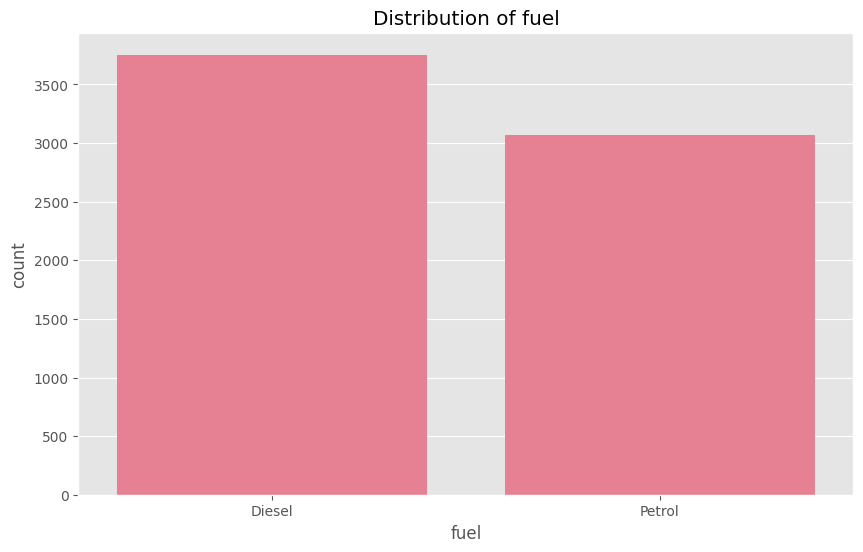

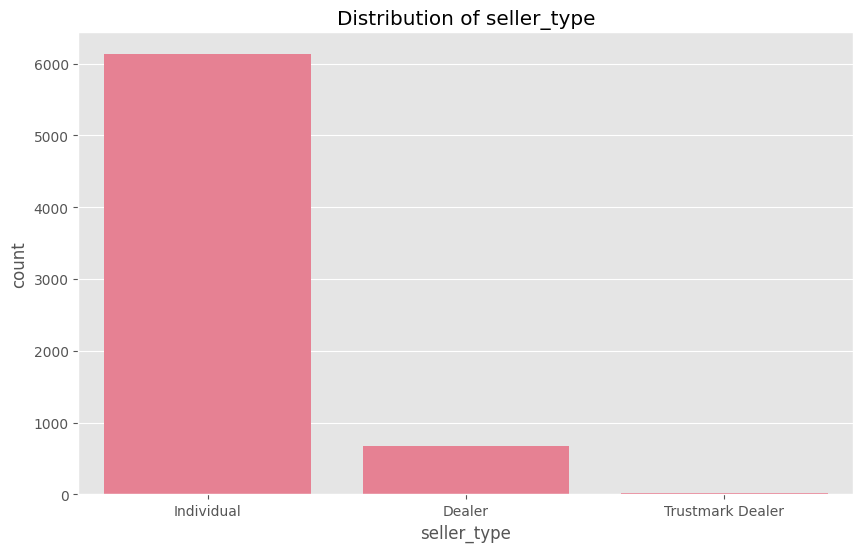

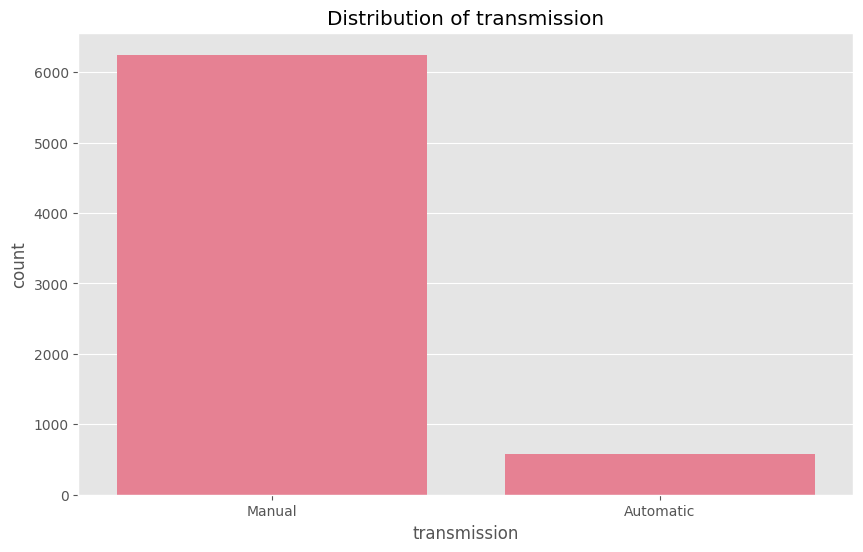

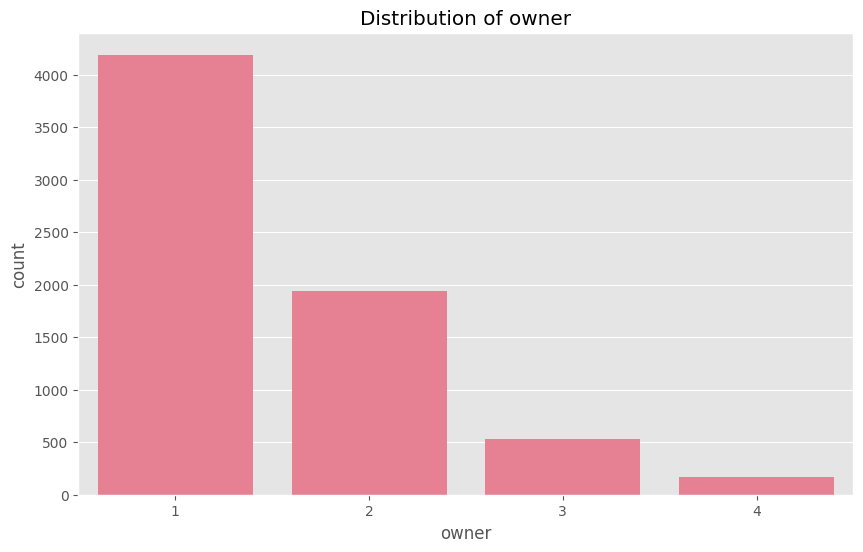

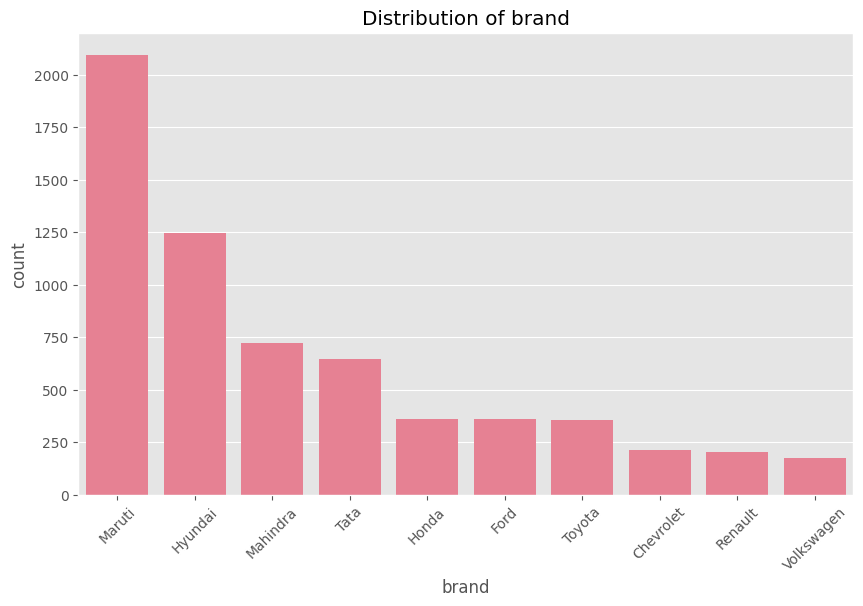

In [27]:
# Visualize categorical features
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']

for col in cat_cols:
    plt.figure(figsize=(10, 6))
    if col == 'brand':  # For brand, show only top 10
        top_brands = data['brand'].value_counts().nlargest(10).index
        sns.countplot(data=data[data['brand'].isin(top_brands)], x=col, order=top_brands)
        plt.xticks(rotation=45)
    else:
        sns.countplot(data=data, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

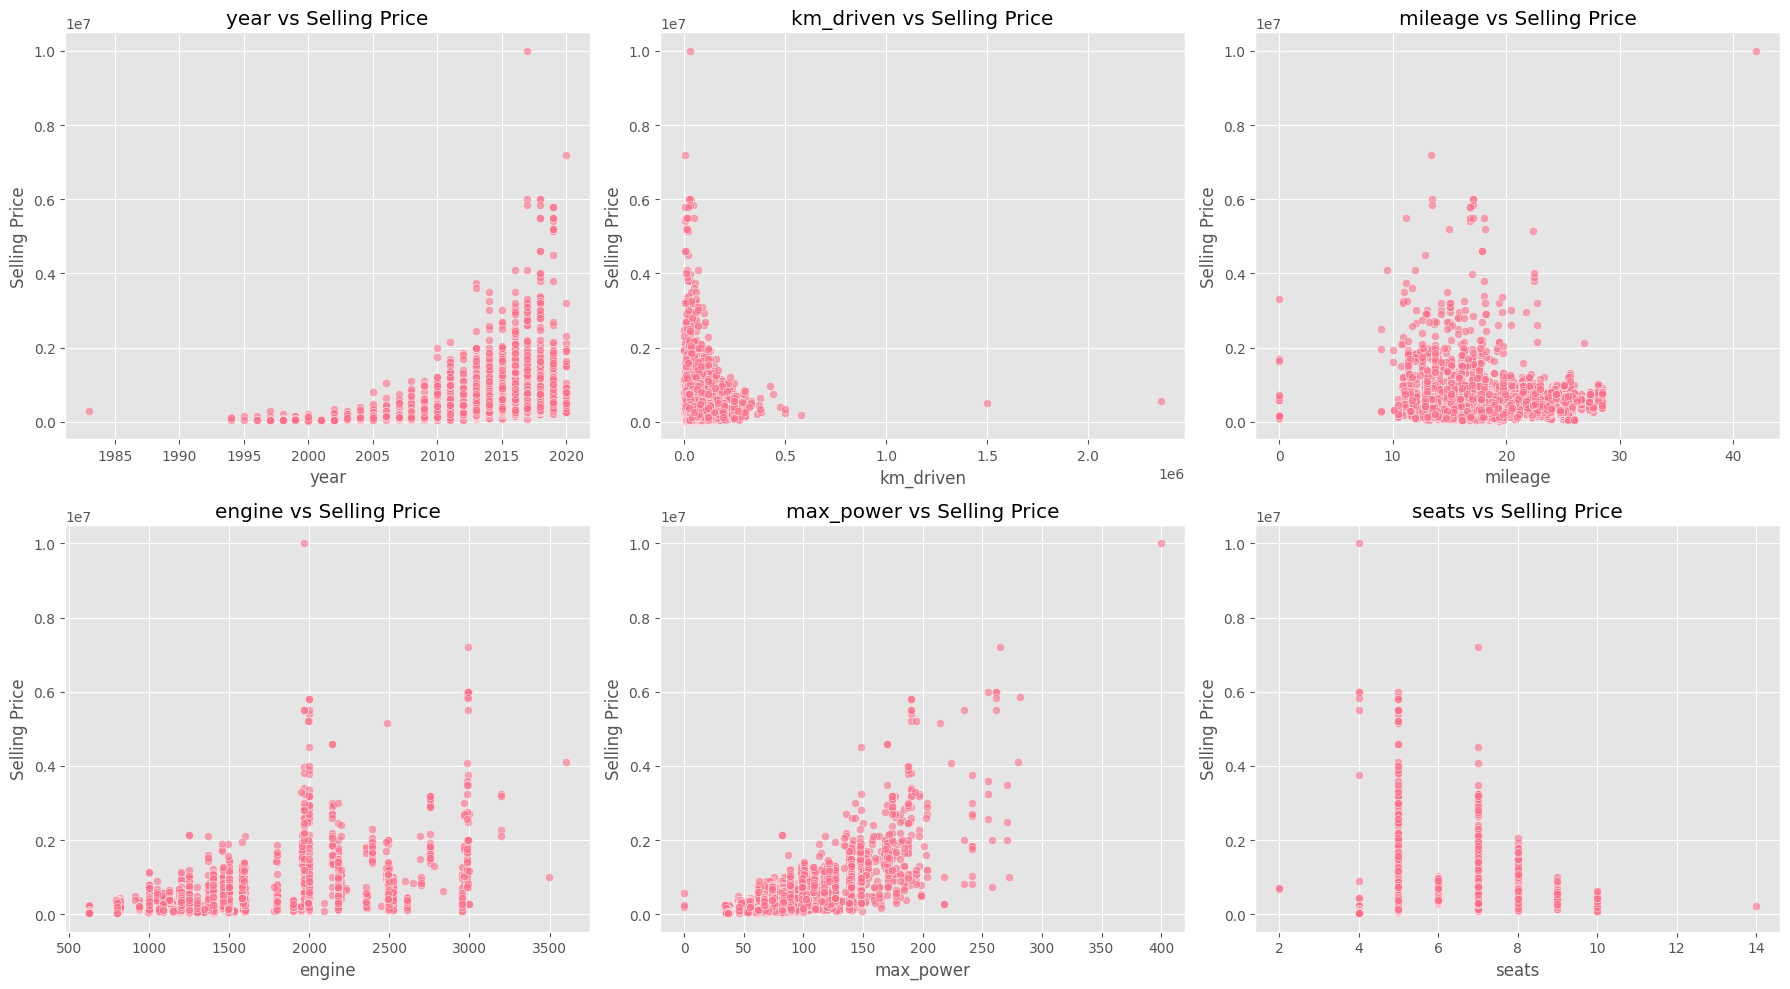

In [28]:
# Analyze relationship between features and selling price
# Numerical features vs selling price
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y=np.exp(data['selling_price']), ax=axes[i], alpha=0.6)
    axes[i].set_title(f"{col} vs Selling Price")
    axes[i].set_ylabel("Selling Price")
    
plt.tight_layout()
plt.show()

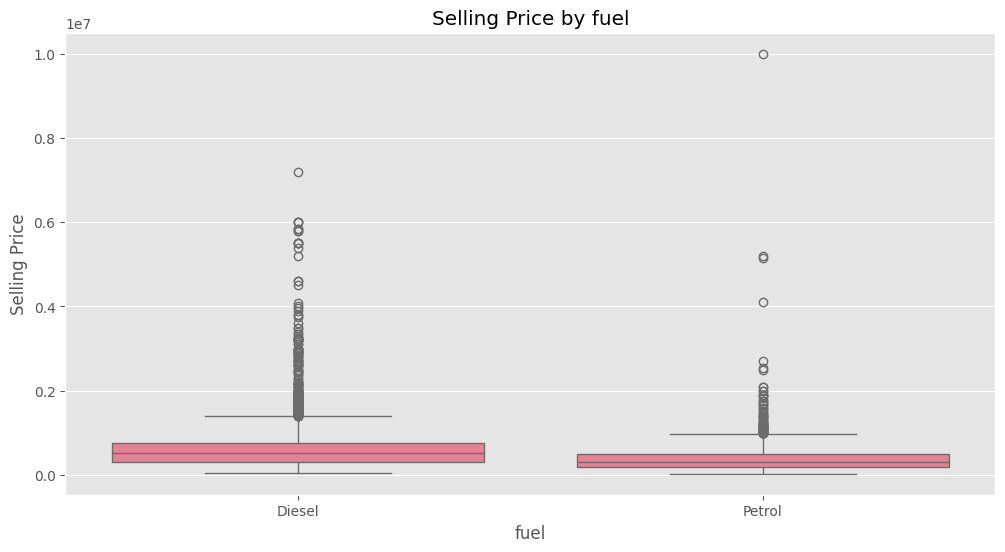

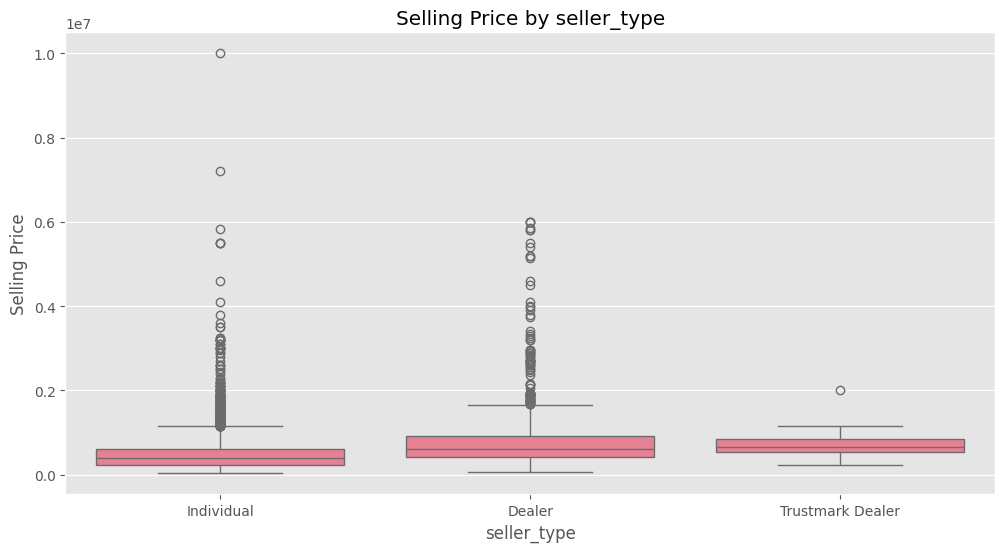

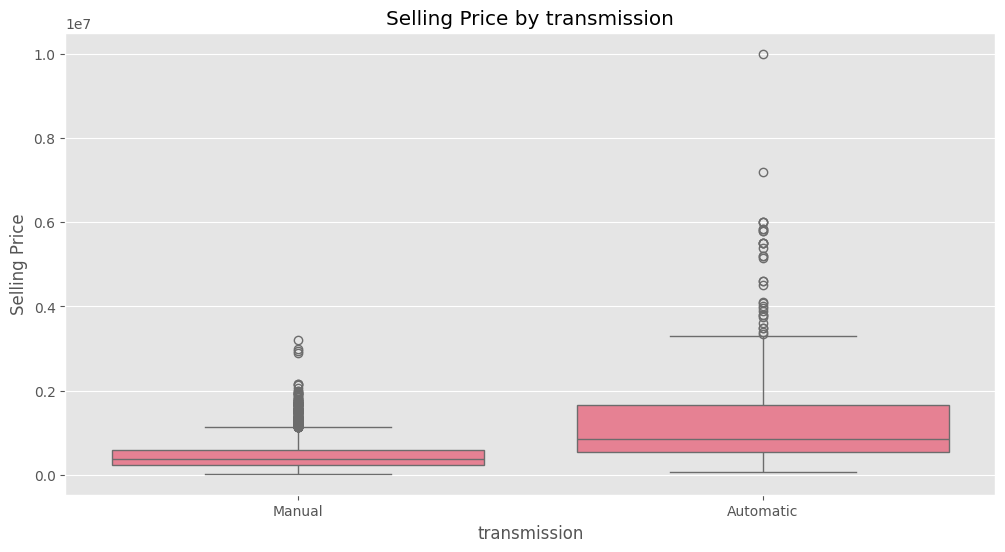

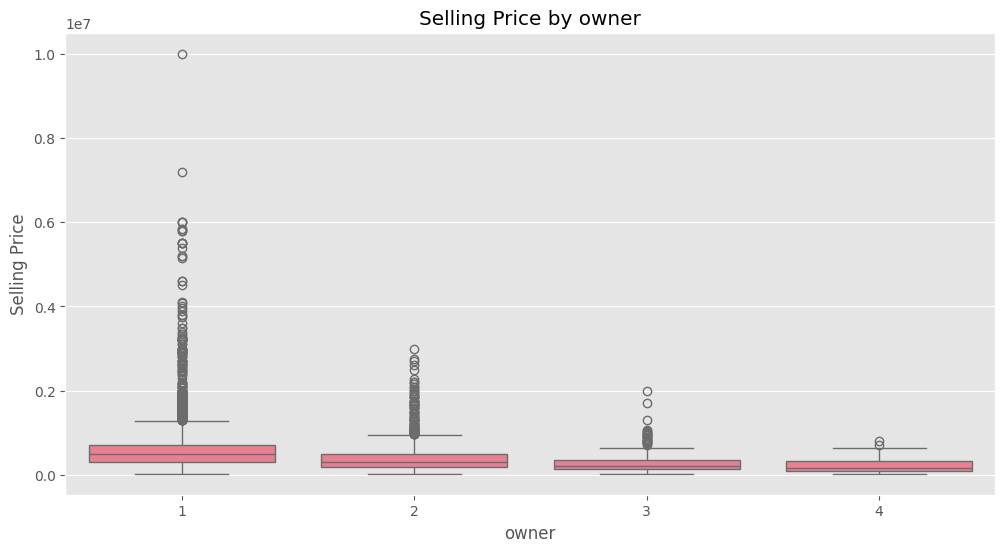

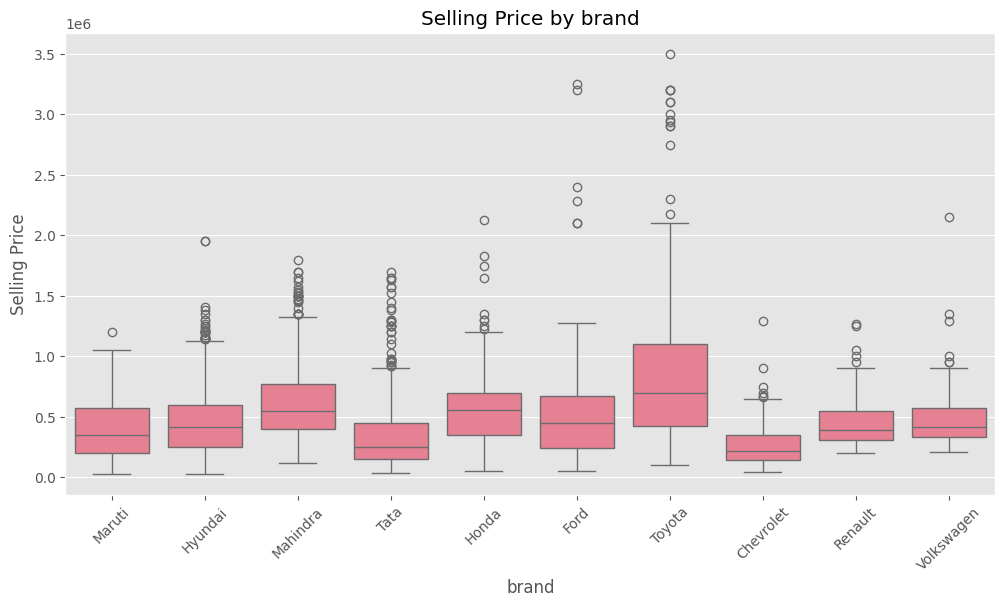

In [29]:
# Categorical features vs selling price
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    if col == 'brand':  # For brand, show only top 10
        top_brands = data['brand'].value_counts().nlargest(10).index
        sns.boxplot(data=data[data['brand'].isin(top_brands)], x=col, y=np.exp(data['selling_price']), order=top_brands)
        plt.xticks(rotation=45)
    else:
        sns.boxplot(data=data, x=col, y=np.exp(data['selling_price']))
    plt.title(f"Selling Price by {col}")
    plt.ylabel("Selling Price")
    plt.show()

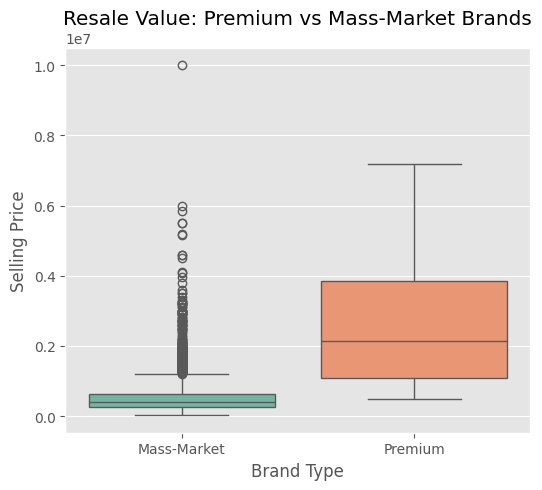

In [30]:
# Focus only on premium vs non-premium
data["brand_type"] = data["brand"].apply(lambda x: "Premium" if x in ["BMW", "Mercedes"] else "Mass-Market")

plt.figure(figsize=(6, 5))
sns.boxplot(
    data=data,
    x="brand_type",
    y=np.exp(data["selling_price"]),
    palette="Set2"
)

plt.title("Resale Value: Premium vs Mass-Market Brands")
plt.ylabel("Selling Price")
plt.xlabel("Brand Type")
plt.show()


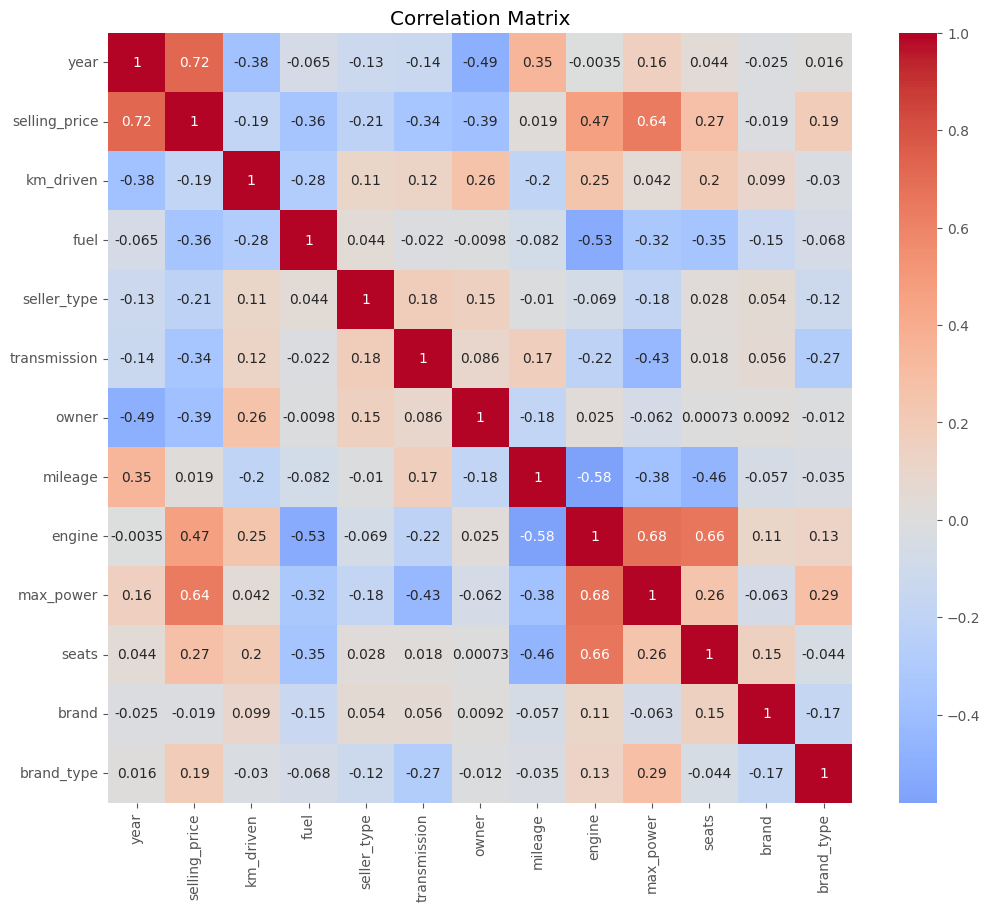

In [31]:
# Correlation analysis
from sklearn.preprocessing import LabelEncoder
# Create a copy for correlation analysis
corr_data = data.copy()

# Encode categorical variables
cat_cols = corr_data.select_dtypes(exclude='number').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    corr_data[col] = le.fit_transform(corr_data[col].astype(str))
    le_dict[col] = le

# Calculate correlation matrix
corr_matrix = corr_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [32]:
# Correlation with target
corr_with_target = corr_matrix['selling_price'].drop('selling_price')
corr_sorted = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index)

print("Feature correlations with selling price:")
print(corr_sorted)

Feature correlations with selling price:
year            0.718678
max_power       0.637513
engine          0.468379
owner          -0.389101
fuel           -0.356654
transmission   -0.343871
seats           0.273511
seller_type    -0.212444
brand_type      0.188333
km_driven      -0.185280
mileage         0.018881
brand          -0.018835
Name: selling_price, dtype: float64


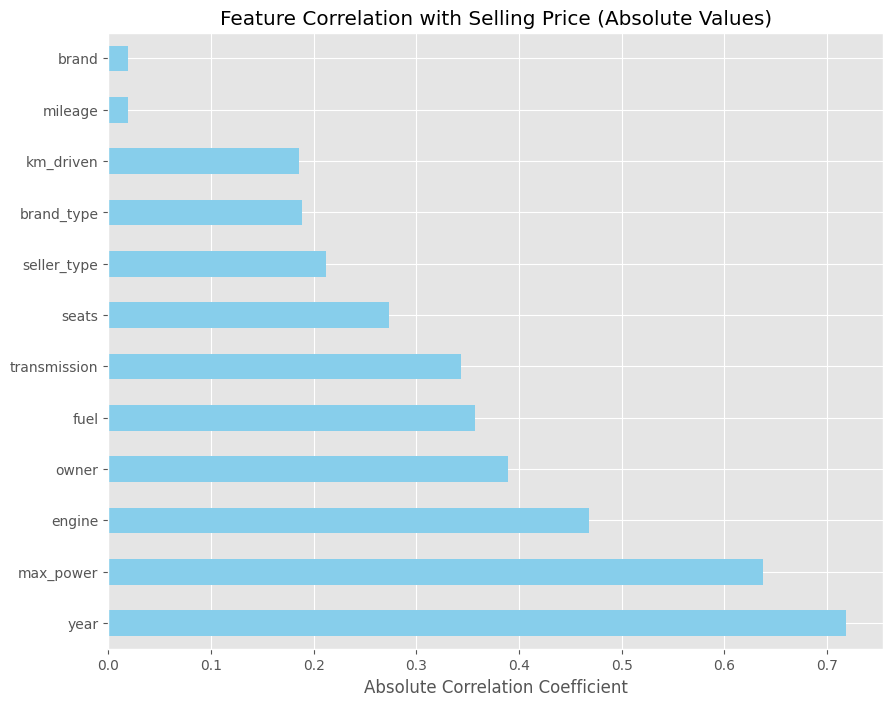

In [33]:
# Plot feature importance based on correlation
plt.figure(figsize=(10, 8))
corr_sorted.abs().plot(kind='barh', color='skyblue')
plt.title("Feature Correlation with Selling Price (Absolute Values)")
plt.xlabel("Absolute Correlation Coefficient")
plt.show()


In [34]:
# Prepare features and target for modeling
feature_cols = ['year', 'max_power', 'engine', 'brand', 'km_driven','mileage']
X = data[feature_cols]
y = data["selling_price"]

In [35]:
# Encode brand column as others are already encoded
le = LabelEncoder()
X.loc[:, 'brand'] = le.fit_transform(X['brand'].astype(str))

In [36]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5461, 6)
Testing set shape: (1366, 6)


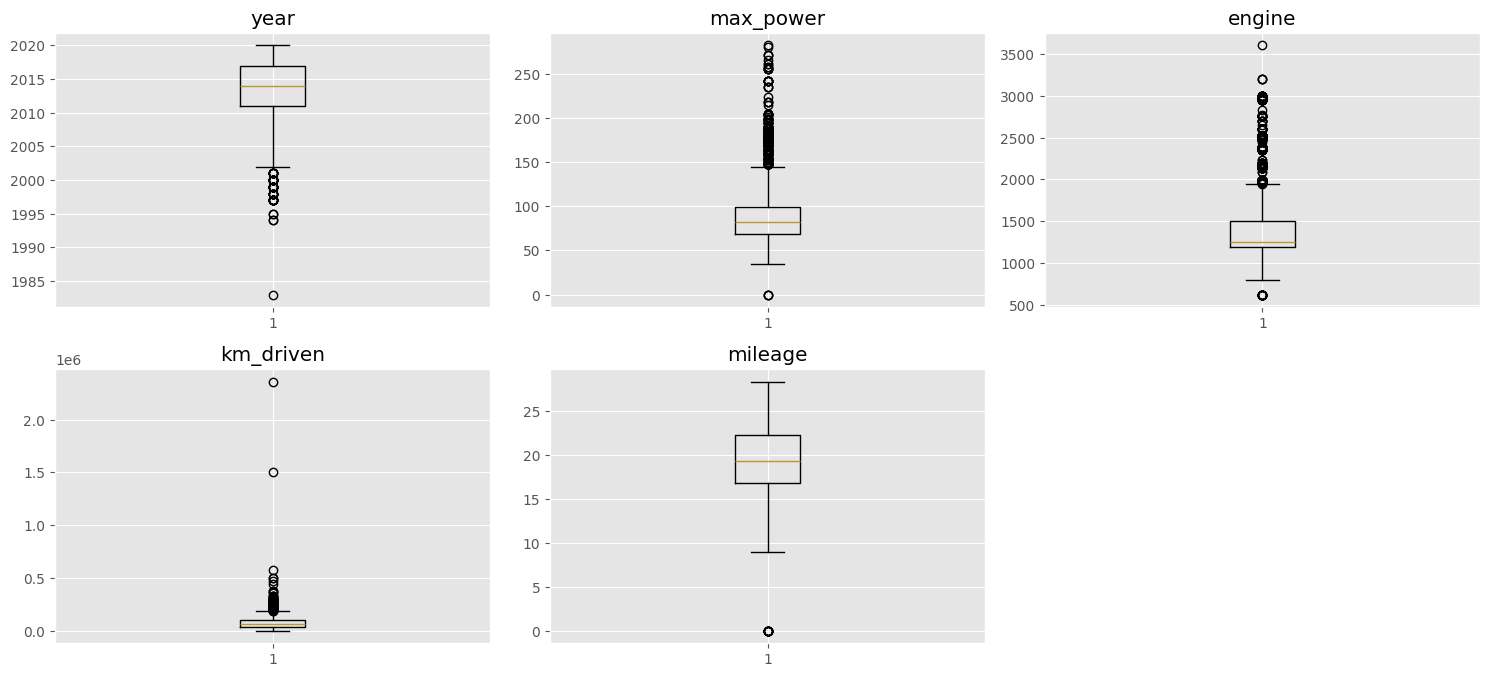

In [37]:
# Check for outliers in numerical features
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    plt.boxplot(X_train[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [38]:
# Define function to count outliers
def outlier_count(col, data=X_train):
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr * 1.5)
    max_val = q75 + (iqr * 1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count / len(data[col]) * 100, 2)
    
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers ({outlier_percent}%)")

print("Outlier analysis:")
for col in num_cols:
    outlier_count(col)

Outlier analysis:
year: 61 outliers (1.12%)
max_power: 307 outliers (5.62%)
engine: 978 outliers (17.91%)
km_driven: 138 outliers (2.53%)
mileage: 15 outliers (0.27%)


In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5461, 6), (5461,), (1366, 6), (1366,))

<H1>LINEAR REGRESSION</H1>

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import mlflow

class LinearRegression:
    def __init__(self,
                 lr=0.001,
                 num_epochs=500,
                 batch_size=50,
                 method='batch',
                 init_method='zeros',
                 use_momentum=False,
                 momentum=0.9,
                 polynomial=False,
                 degree=2,
                 regularization=None,
                 kfold_splits=3,
                 random_state=42):
        
        # Training params
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method = method
        self.init_method = init_method.lower()
        self.use_momentum = use_momentum
        self.momentum = momentum
        self.velocity = None
        self.regularization = regularization
        
        # Polynomial
        self.polynomial = polynomial
        self.degree = degree
        self.poly_transformer = None
        
        # Scaling and encoding
        self.scaler = None
        self.label_encoders = {}
        self.categorical_cols = []
        self.feature_cols = None
        
        # KFold
        self.kfold = KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state)
        self.kfold_scores = []

    # ---------------- Metrics ----------------
    def mse(self, ytrue, ypred):
        return np.mean((ypred - ytrue)**2)

    def r2(self, ytrue, ypred):
        ss_res = np.sum((ytrue - ypred)**2)
        ss_tot = np.sum((ytrue - np.mean(ytrue))**2)
        return 1 - (ss_res / ss_tot)

    # ---------------- Weight Initialization ----------------
    def _initialize_weights(self, n_features):
        if self.init_method == 'xavier':
            limit = np.sqrt(1 / n_features)
            return np.random.uniform(-limit, limit, size=n_features)
        else:
            return np.zeros(n_features)

    # ---------------- Preprocessing ----------------
    def _preprocess_X(self, X, fit=True):
        X = X.copy()
        # Identify numeric and categorical columns
        if self.feature_cols is None:
            self.feature_cols = X.columns.tolist()
        if not self.categorical_cols:
            self.categorical_cols = X.select_dtypes(include='object').columns.tolist()

        # Encode categorical columns
        for col in self.categorical_cols:
            if fit:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le
            else:
                le = self.label_encoders.get(col)
                if le is None:
                    raise ValueError(f"LabelEncoder for {col} not found")
                # Handle unseen labels
                X[col] = X[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else 0)

        # Polynomial features
        X_poly = X.values
        if self.polynomial:
            if fit:
                poly = PolynomialFeatures(degree=self.degree, include_bias=False)
                X_poly = poly.fit_transform(X_poly)
                self.poly_transformer = poly
            else:
                if self.poly_transformer is None:
                    raise ValueError("Polynomial transformer not fitted")
                X_poly = self.poly_transformer.transform(X_poly)

        # Scaling
        if fit:
            self.scaler = MinMaxScaler()
            X_poly = self.scaler.fit_transform(X_poly)
        else:
            if self.scaler is None:
                raise ValueError("Scaler not fitted")
            X_poly = self.scaler.transform(X_poly)

        # Add bias
        X_poly = np.c_[np.ones(X_poly.shape[0]), X_poly]
        return X_poly

    # ---------------- Train Step ----------------
    def _train_step(self, X, y):
        yhat = X @ self.theta
        grad = (X.T @ (yhat - y)) / X.shape[0]
        if self.regularization is not None:
            grad += self.regularization.derivation(self.theta)
        if self.use_momentum:
            self.velocity = self.momentum * self.velocity + self.lr * grad
            self.theta -= self.velocity
        else:
            self.theta -= self.lr * grad
        return self.mse(y, yhat)

    # ---------------- Fit ----------------
    def fit(self, X_train, y_train):
        self.kfold_scores = []
        self.val_loss_old = np.inf

        for fold, (train_idx, val_idx) in enumerate(self.kfold.split(X_train)):
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_val = y_train.iloc[val_idx]

            # Preprocess
            X_fold_train_proc = self._preprocess_X(X_fold_train, fit=True)
            X_fold_val_proc = self._preprocess_X(X_fold_val, fit=False)
            
            self.theta = self._initialize_weights(X_fold_train_proc.shape[1])
            if self.use_momentum:
                self.velocity = np.zeros_like(self.theta)

            # Log fold
            mlflow.log_params({
                f"fold{fold}_lr": self.lr,
                f"fold{fold}_init_method": self.init_method,
                f"fold{fold}_use_momentum": self.use_momentum,
                f"fold{fold}_momentum": self.momentum,
                f"fold{fold}_polynomial": self.polynomial,
                f"fold{fold}_degree": self.degree
            })

            for epoch in range(self.num_epochs):
                perm = np.random.permutation(X_fold_train_proc.shape[0])
                X_shuffled = X_fold_train_proc[perm]
                y_shuffled = y_fold_train.to_numpy()[perm] if hasattr(y_fold_train, "to_numpy") else y_fold_train[perm]

                # Train step
                if self.method == 'sto':
                    for i in range(X_shuffled.shape[0]):
                        train_loss = self._train_step(X_shuffled[i].reshape(1, -1), y_shuffled[i])
                elif self.method == 'mini':
                    for i in range(0, X_shuffled.shape[0], self.batch_size):
                        X_batch = X_shuffled[i:i+self.batch_size]
                        y_batch = y_shuffled[i:i+self.batch_size]
                        train_loss = self._train_step(X_batch, y_batch)
                else:
                    train_loss = self._train_step(X_shuffled, y_shuffled)

                val_loss = self.mse(X_fold_val_proc @ self.theta, y_fold_val.to_numpy())
                if np.allclose(val_loss, self.val_loss_old):
                    break
                self.val_loss_old = val_loss

            self.kfold_scores.append(val_loss)
            print(f"Fold {fold}: {val_loss}")

    # ---------------- Predict ----------------
    def predict(self, X):
        X_proc = self._preprocess_X(X, fit=False)
        return X_proc @ self.theta

    # ---------------- Coefficients ----------------
    def coef_(self):
        return self.theta[1:]

    def intercept_(self):
        return self.theta[0]


In [42]:
class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, theta):  #__call__ allows us to call class as method
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(theta))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(theta))
        return (l1_contribution + l2_contribution)

    def derivation(self, theta):
        l1_derivation = self.l * self.l_ratio * np.sign(theta)
        l2_derivation = self.l * (1 - self.l_ratio) * theta
        return (l1_derivation + l2_derivation)
    
class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, method)
        
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, method)
        
class ElasticNet(LinearRegression):
    
    def __init__(self, method, lr, l, l_ratio=0.5):
        self.regularization = ElasticPenalty(l, l_ratio)
        super().__init__(self.regularization, lr, method)


In [43]:
#helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def run_experiment(
    model_class, X_train, y_train, X_test, y_test,
    method='batch', lr=0.001, init_method='zeros',
    use_momentum=False, momentum=0.9,
    polynomial=False, degree=2,
    l=0.1, l_ratio=0.5,
    run_name="experiment"
):
    # Only LinearRegression for now
    model = LinearRegression(
        lr=lr, method=method, init_method=init_method,
        use_momentum=use_momentum, momentum=momentum,
        polynomial=polynomial, degree=degree,
    )

    # Top-level MLflow run
    with mlflow.start_run(run_name=run_name):
        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        mse_val = model.mse(y_test, y_pred)
        r2_val = model.r2(y_test, y_pred)
        print(f"Test MSE: {mse_val}, Test R2: {r2_val}")

        # Log main metrics & parameters
        mlflow.log_params({
            "model_class": model_class,
            "method": method,
            "lr": lr,
            "init_method": init_method,
            "use_momentum": use_momentum,
            "momentum": momentum,
            "polynomial": polynomial,
            "degree": degree
        })
        mlflow.log_metric("mse", mse_val)
        mlflow.log_metric("r2", r2_val)

        # Feature importance
        if polynomial and model.poly_transformer is not None:
            feature_names = ["bias"] + list(model.poly_transformer.get_feature_names_out(
                X_train.columns if hasattr(X_train, "columns") else [f"x{i+1}" for i in range(X_train.shape[1])]
            ))
        else:
            feature_names = ["bias"] + [f"x{i+1}" for i in range(X_train.shape[1])]

        # Feature importance
        fi = pd.Series(np.abs(model.theta), index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(8,5))
        sns.barplot(x=fi.values, y=fi.index)
        plt.title("Feature Importance")
        plt.xlabel("Absolute Coefficient Value")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "feature_importance.png")  # log first
        plt.show()
        plt.close()

        # Actual vs Predicted
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Actual vs Predicted")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "actual_vs_predicted.png")
        plt.show()
        plt.close()

        # Residuals vs Predicted
        residuals = y_test - y_pred
        plt.figure(figsize=(6,4))
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='--')
        plt.xlabel("Predicted")
        plt.ylabel("Residuals")
        plt.title("Residuals vs Predicted")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "residuals_vs_predicted.png")
        plt.show()
        plt.close()

        return {"model": model, "mse": mse_val, "r2": r2_val}


In [45]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (5461, 6)
y_train shape: (5461,)



🚀 Running Model Class: Normal
Fold 0: 0.19672258023930753
Fold 1: 0.14077139657513799
Fold 2: 0.15607096609254748
Test MSE: 0.1622483469945517, Test R2: 0.708045365159435


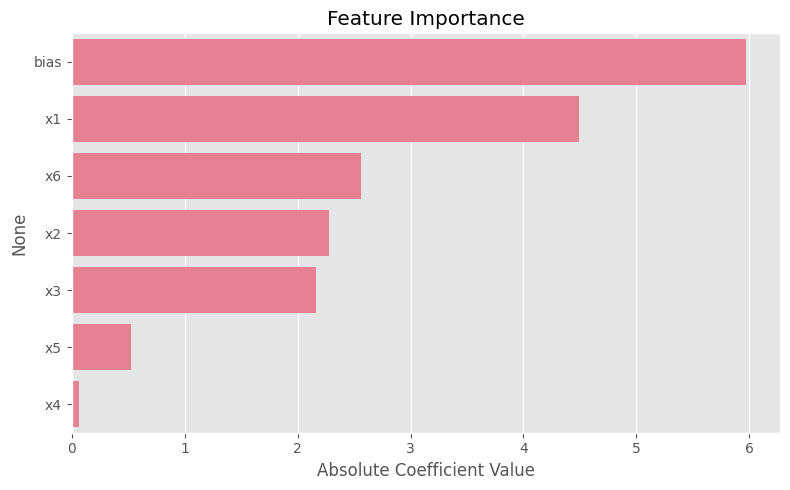

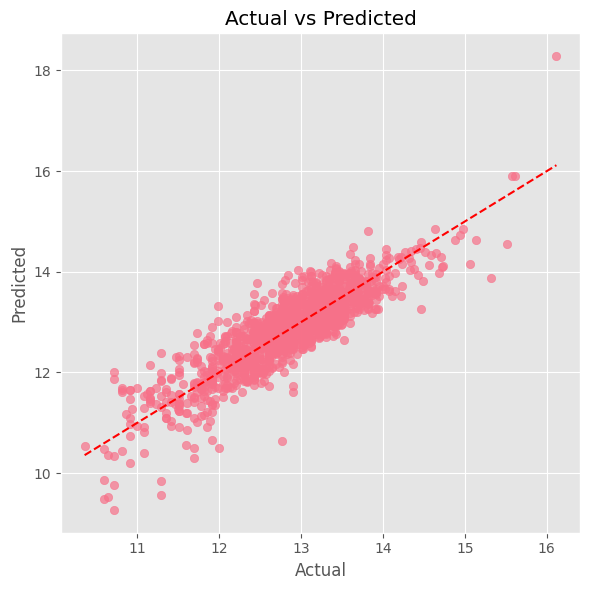

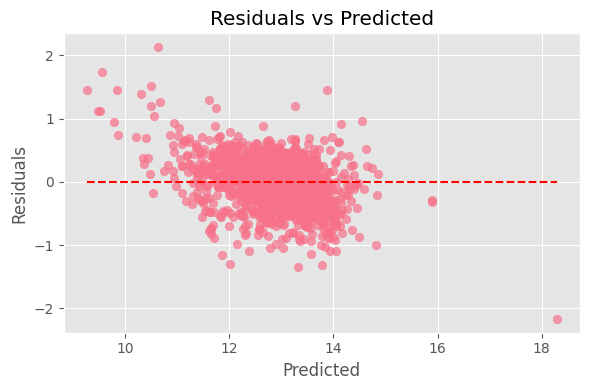

🏃 View run Normal_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/5d9a4994a45d422f8977bda00729429f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.162248, r2=0.708045

🚀 Running Model Class: Ridge
Fold 0: 0.5365879340534617
Fold 1: 0.13909355591034303
Fold 2: 0.15552485784074419
Test MSE: 0.160102604064319, Test R2: 0.7119064805745513


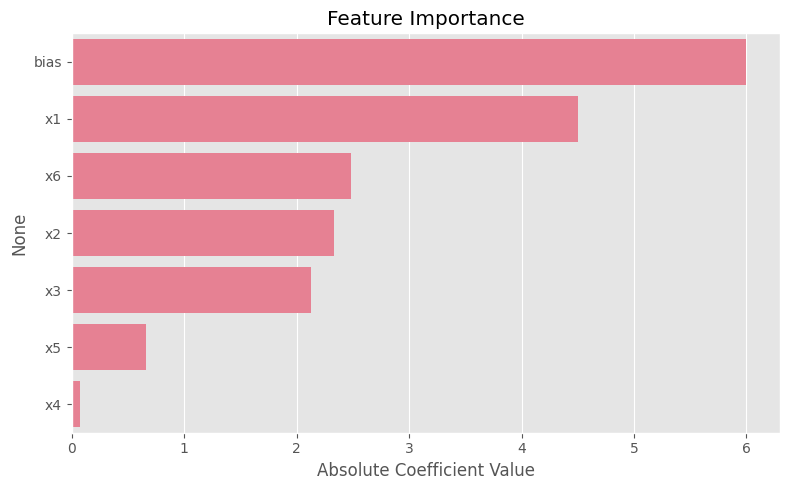

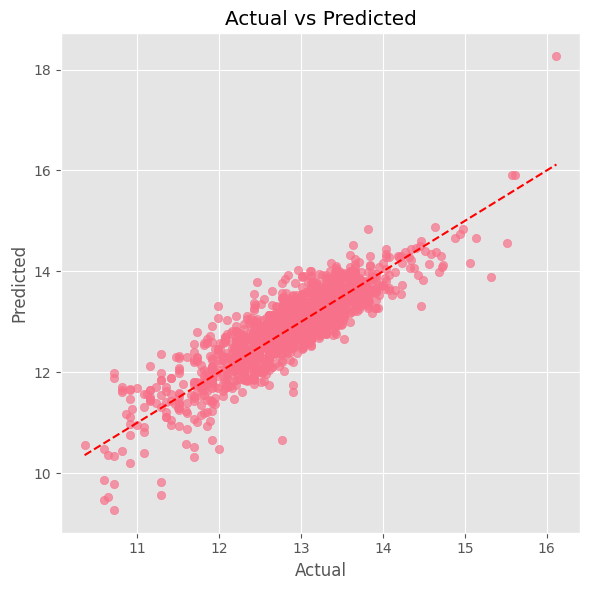

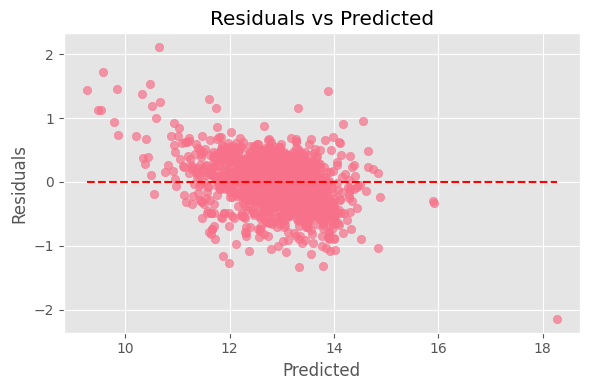

🏃 View run Ridge_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/0c2810c27e6d476983ccf08b4eac5ae5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.160103, r2=0.711906

🚀 Running Model Class: Lasso
Fold 0: 0.19400099238033988
Fold 1: 0.12983163320824972
Fold 2: 0.15087428592410443
Test MSE: 0.15795595626890283, Test R2: 0.7157692242317368


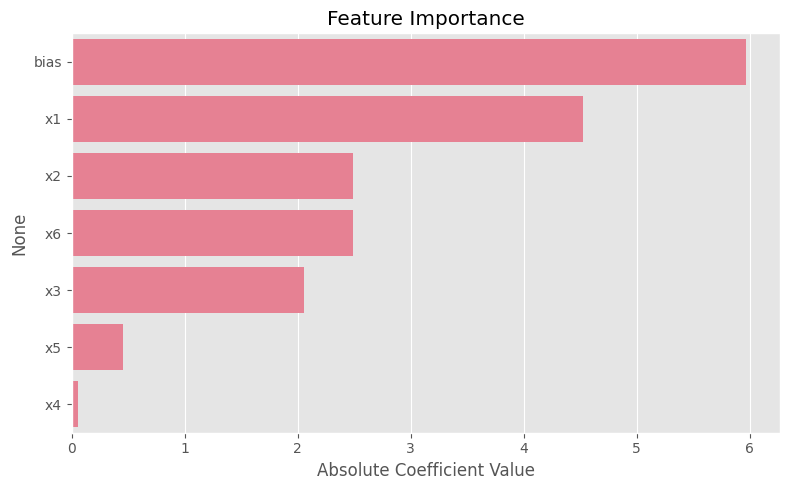

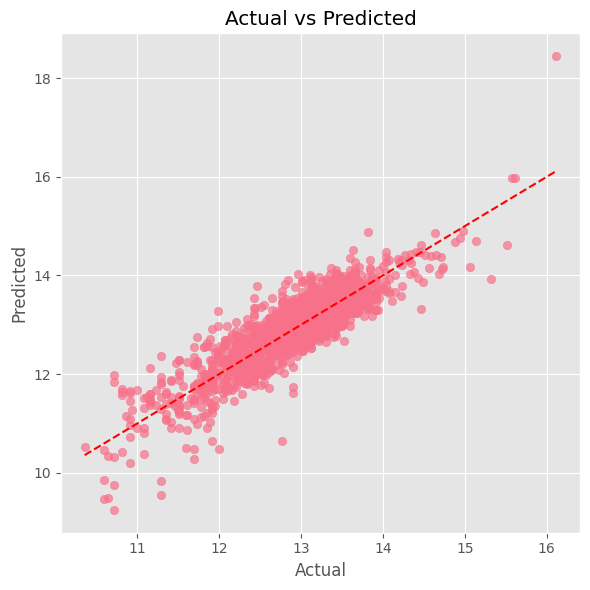

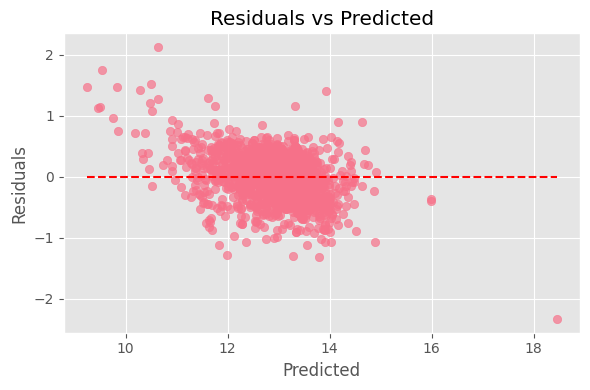

🏃 View run Lasso_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/6ddb06623f534b88b4852bb90d6e8a1d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.157956, r2=0.715769

🚀 Running Model Class: ElasticNet
Fold 0: 0.19958037556179603
Fold 1: 0.14431234838638607
Fold 2: 0.15789304377232824
Test MSE: 0.16255334392797471, Test R2: 0.7074965443549432


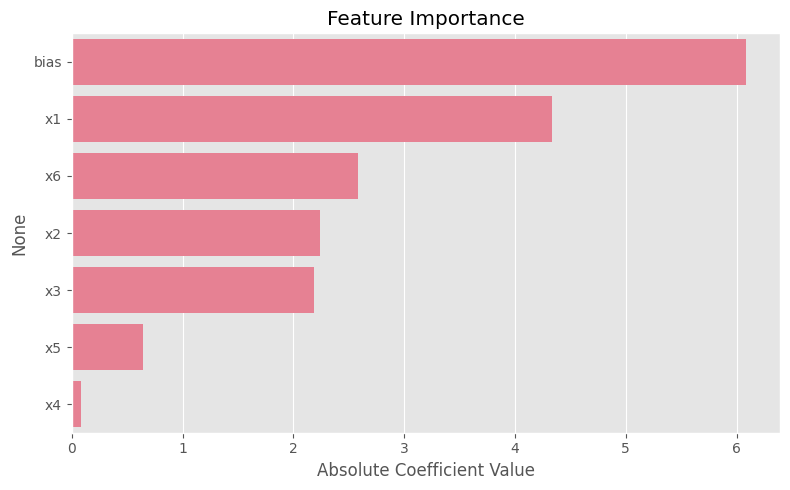

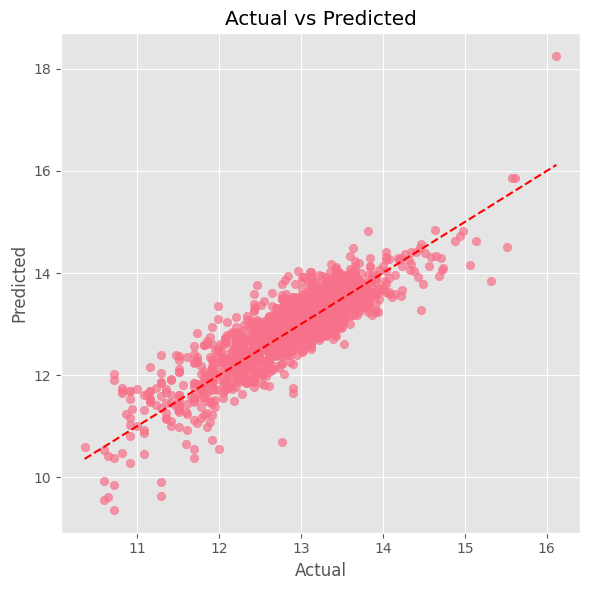

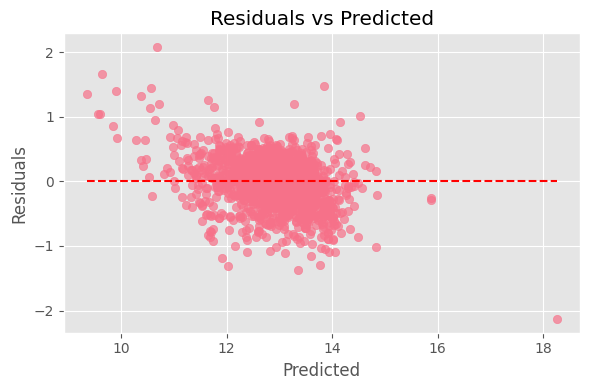

🏃 View run ElasticNet_FullData at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/9aa00f82b51e4b99913133d8b57d1f63
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.162553, r2=0.707497


model_class       mse        r2
0       Lasso  0.157956  0.715769
1       Ridge  0.160103  0.711906
2      Normal  0.162248  0.708045
3  ElasticNet  0.162553  0.707497

In [46]:
import numpy as np
import pandas as pd
from copy import deepcopy
import mlflow

# -------------------------
# Comparison: Model classes
# -------------------------
model_classes = ["Normal", "Ridge", "Lasso", "ElasticNet"]
fixed_params = {
    "degree": 1,
    "method": "batch",
    "init_method": "xavier",
    "lr": 0.01,
    "use_momentum": True,
    "momentum": 0.9
}

results_classes = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for model_class in model_classes:
    print(f"\n🚀 Running Model Class: {model_class}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class=model_class,
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=fixed_params["init_method"],
            lr=fixed_params["lr"],
            use_momentum=fixed_params["use_momentum"],
            run_name=f"{model_class}_FullData"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_classes.append({
            "model_class": model_class,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for {model_class}: {e}")
        results_classes.append({
            "model_class": model_class,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_classes = pd.DataFrame(results_classes).sort_values("r2", ascending=False)
df_classes.reset_index(drop=True, inplace=True)
df_classes



🚀 Running Lasso with use_momentum=True
Fold 0: 0.2036193965143186
Fold 1: 0.13947684565167673
Fold 2: 0.15604017090894218
Test MSE: 0.15928548914530422, Test R2: 0.7133768221356382


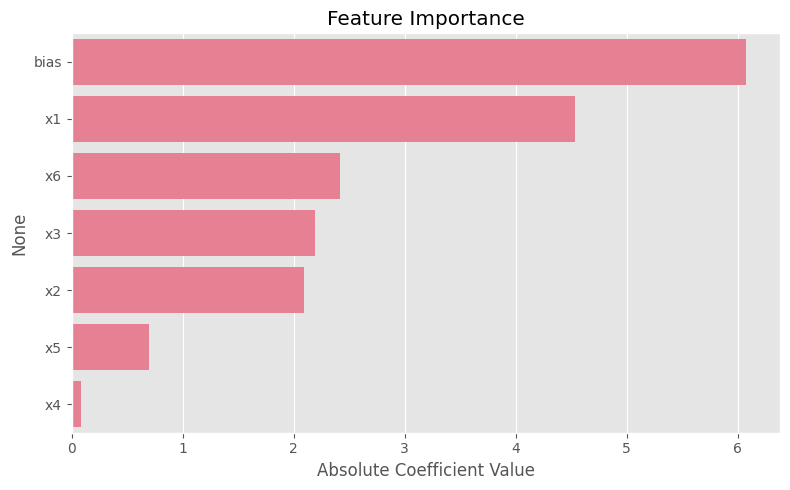

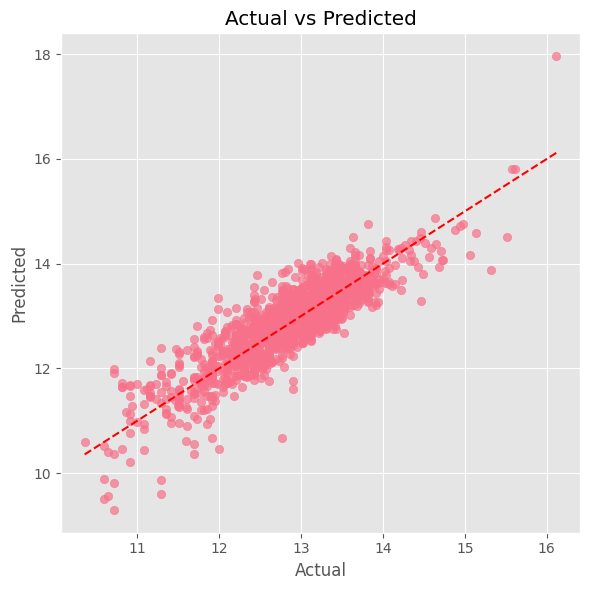

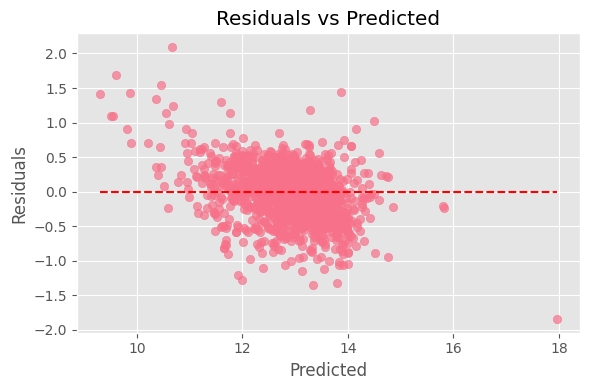

🏃 View run Lasso_Momentum_True at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/7a7e39518d8046ae8c339dfd88ecc924
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.159285, r2=0.713377

🚀 Running Lasso with use_momentum=False
Fold 0: 0.8517536551523599
Fold 1: 0.8401036951691474
Fold 2: 0.7477467734989147
Test MSE: 0.7405060891962912, Test R2: -0.33248929109754144


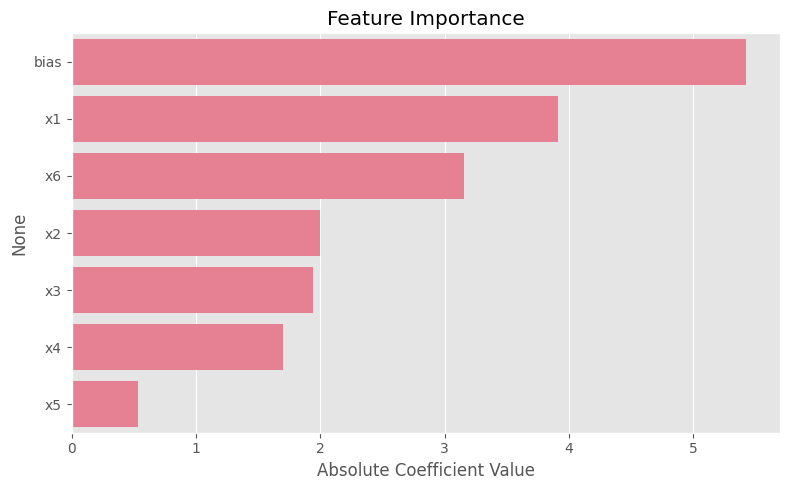

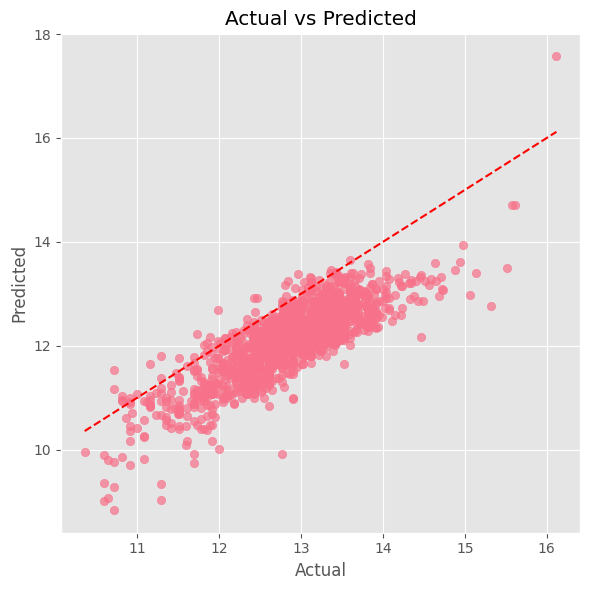

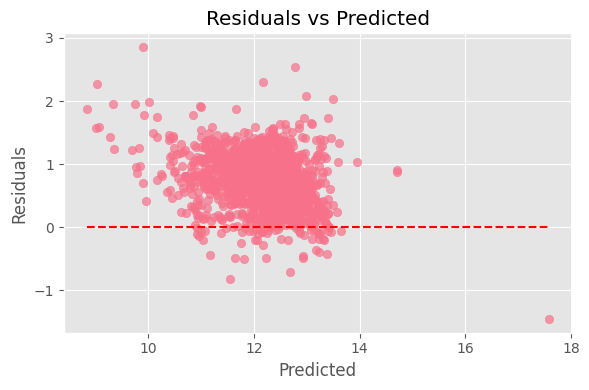

🏃 View run Lasso_Momentum_False at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/fe08ce114c6f412695419fdbde2cbf37
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.740506, r2=-0.332489


use_momentum       mse        r2
0          True  0.159285  0.713377
1         False  0.740506 -0.332489

In [47]:
import pandas as pd
from copy import deepcopy

# -------------------------
# Comparison: Lasso + momentum
# -------------------------
momentum_options = [True, False]
fixed_params = {
    "degree": 1,
    "method": "batch",
    "init_method": "xavier",
    "lr": 0.01,
    "momentum": 0.9  # Only used if use_momentum=True
}

results_momentum = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for use_momentum in momentum_options:
    print(f"\n🚀 Running Lasso with use_momentum={use_momentum}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Lasso",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=fixed_params["init_method"],
            lr=fixed_params["lr"],
            use_momentum=use_momentum,
            momentum=fixed_params["momentum"],
            run_name=f"Lasso_Momentum_{use_momentum}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_momentum.append({
            "use_momentum": use_momentum,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for use_momentum={use_momentum}: {e}")
        results_momentum.append({
            "use_momentum": use_momentum,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_momentum = pd.DataFrame(results_momentum).sort_values("r2", ascending=False)
df_momentum.reset_index(drop=True, inplace=True)
df_momentum


🚀 Running Lasso with method=sto
Fold 0: 0.11102601906919235
Fold 1: 0.1093392712344852
Fold 2: 0.10611094740903751
Test MSE: 0.09856775214222219, Test R2: 0.8226341739882


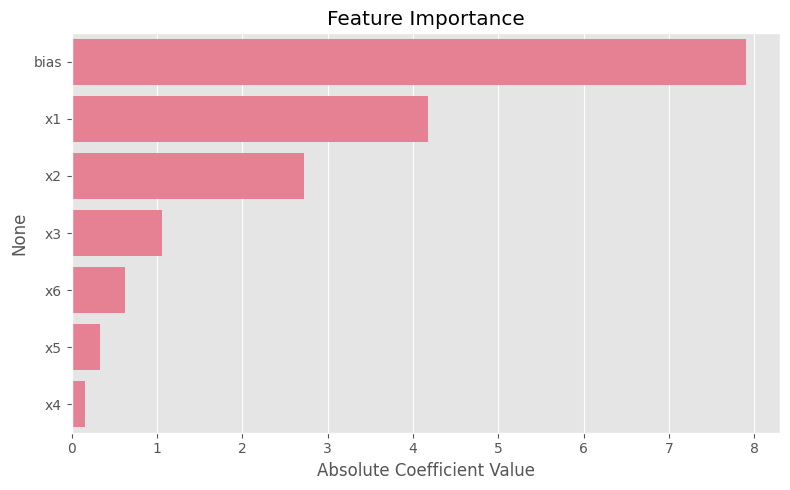

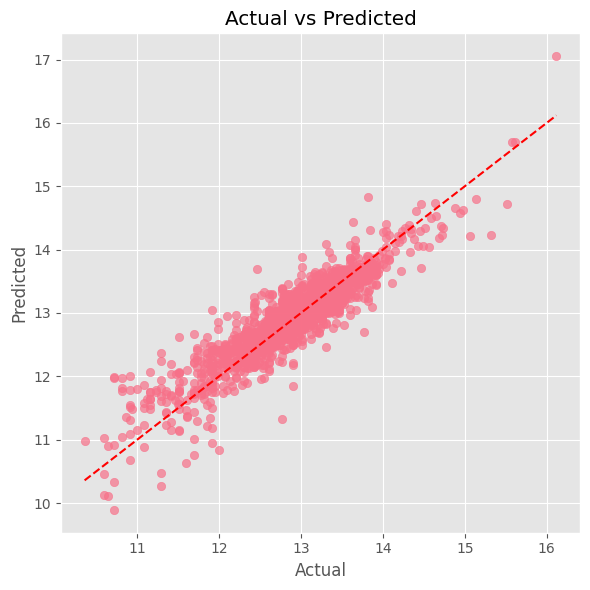

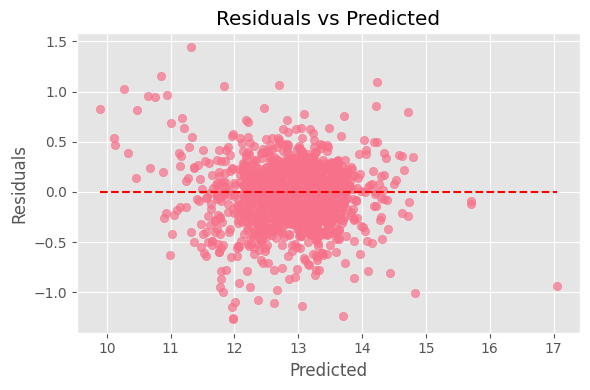

🏃 View run Lasso_Method_sto at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/c1aa64b4082c4d6292205615290e9ef5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.098568, r2=0.822634

🚀 Running Lasso with method=mini
Fold 0: 0.12065599949403852
Fold 1: 0.10270815897540012
Fold 2: 0.11022212959463787
Test MSE: 0.10313829526299613, Test R2: 0.8144097989941459


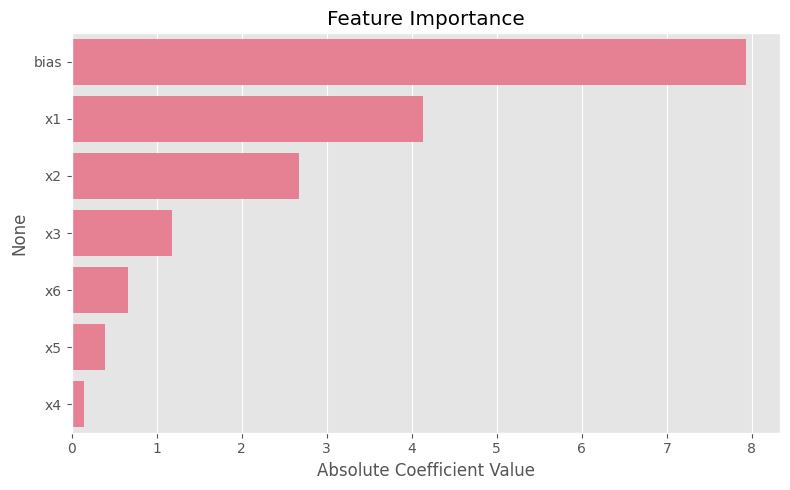

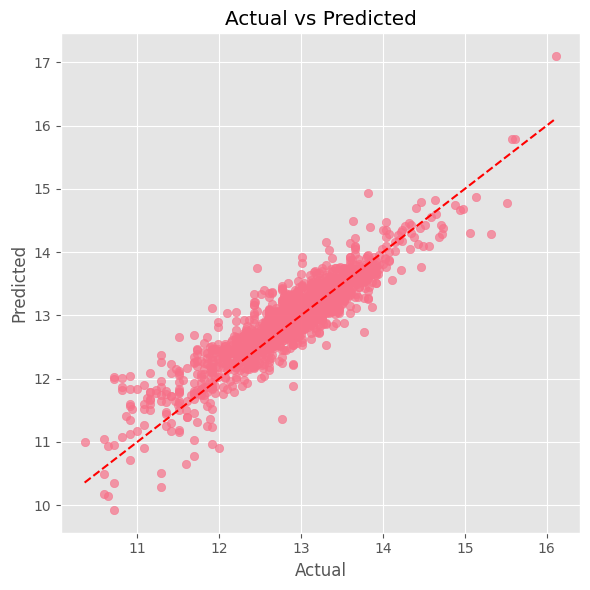

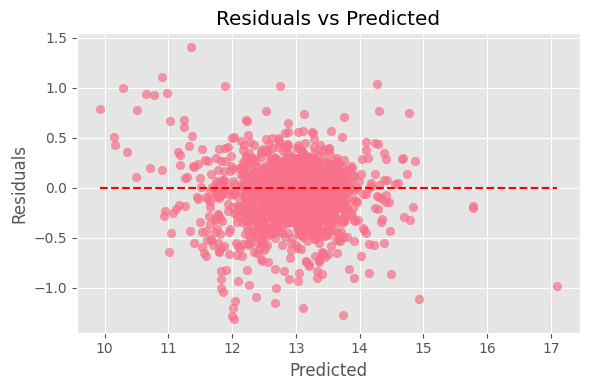

🏃 View run Lasso_Method_mini at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/eea53b24d48049c0863d981f257569e7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.103138, r2=0.814410

🚀 Running Lasso with method=batch
Fold 0: 0.19670138497004608
Fold 1: 0.14669740840662057
Fold 2: 0.14793253310632026
Test MSE: 0.15276291182761556, Test R2: 0.7251137471292044


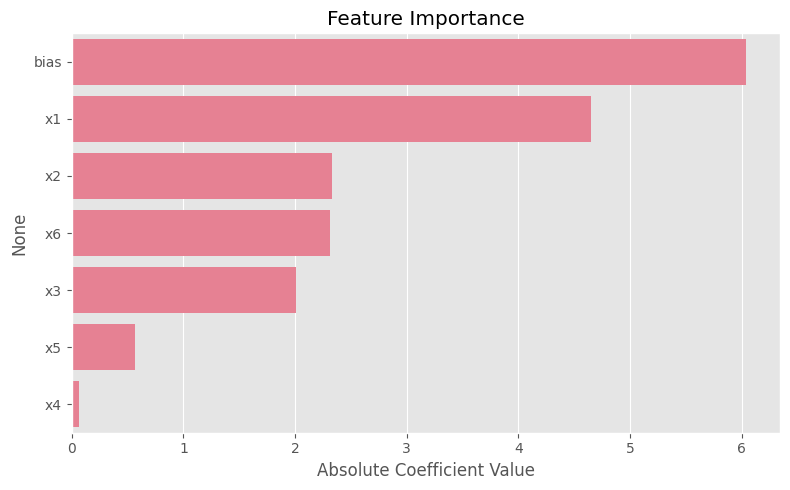

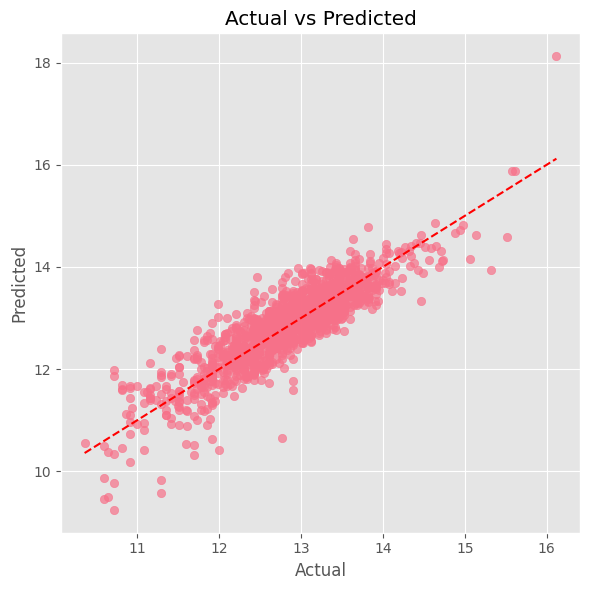

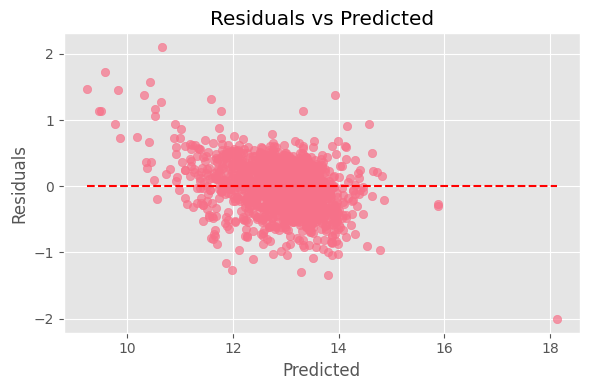

🏃 View run Lasso_Method_batch at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/ff539b4241204ad1b7e2b92b01897df2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.152763, r2=0.725114


method       mse        r2
0    sto  0.098568  0.822634
1   mini  0.103138  0.814410
2  batch  0.152763  0.725114

In [48]:
import pandas as pd
from copy import deepcopy

# -------------------------
# Comparison: Lasso with different optimization methods
# -------------------------
methods = ["sto", "mini", "batch"]
fixed_params = {
    "degree": 1,
    "init_method": "xavier",
    "lr": 0.01,
    "use_momentum": True,
    "momentum": 0.9,  # ignored since use_momentum=False
    "batch_size": 50
}

results_methods = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for method in methods:
    print(f"\n🚀 Running Lasso with method={method}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Lasso",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=method,
            init_method=fixed_params["init_method"],
            lr=fixed_params["lr"],
            use_momentum=fixed_params["use_momentum"],
            momentum=fixed_params["momentum"],
            run_name=f"Lasso_Method_{method}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_methods.append({
            "method": method,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for method={method}: {e}")
        results_methods.append({
            "method": method,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_methods = pd.DataFrame(results_methods).sort_values("r2", ascending=False)
df_methods.reset_index(drop=True, inplace=True)
df_methods



🚀 Running Lasso with init_method=zeros
Fold 0: 0.11533201681035572
Fold 1: 0.19617421258024897
Fold 2: 0.16270654405533508
Test MSE: 0.15846747507997325, Test R2: 0.7148487816480896


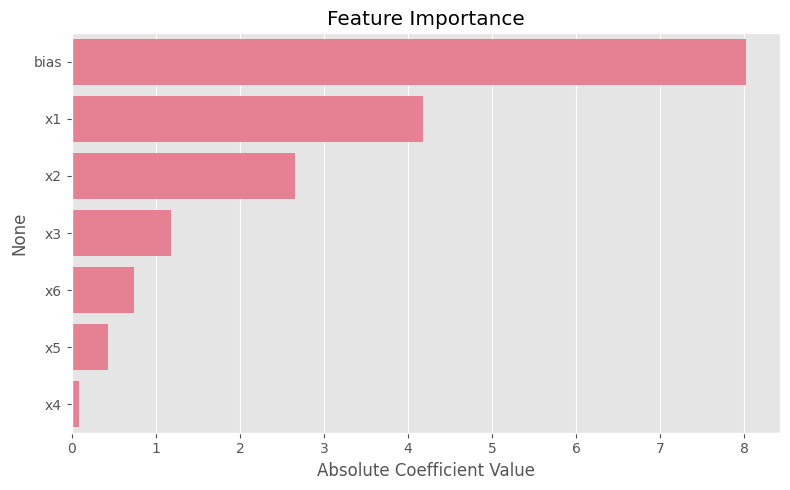

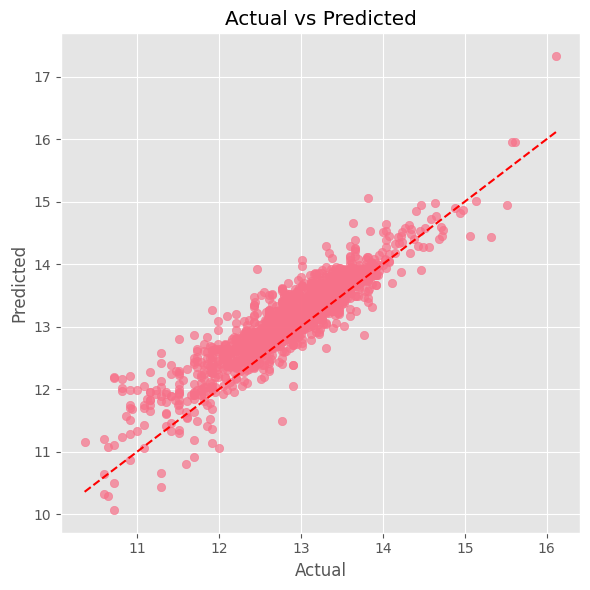

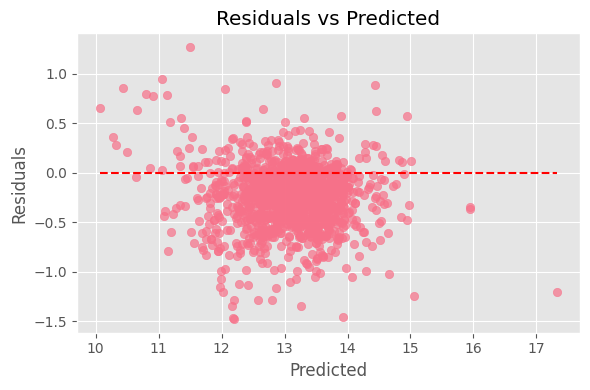

🏃 View run Lasso_Init_zeros at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/a9073ad34c3e4fcc94e11c60b656fe56
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.158467, r2=0.714849

🚀 Running Lasso with init_method=xavier
Fold 0: 0.12804753735799404
Fold 1: 0.10155855030485464
Fold 2: 0.12211704625298342
Test MSE: 0.10923792268459925, Test R2: 0.803433942971419


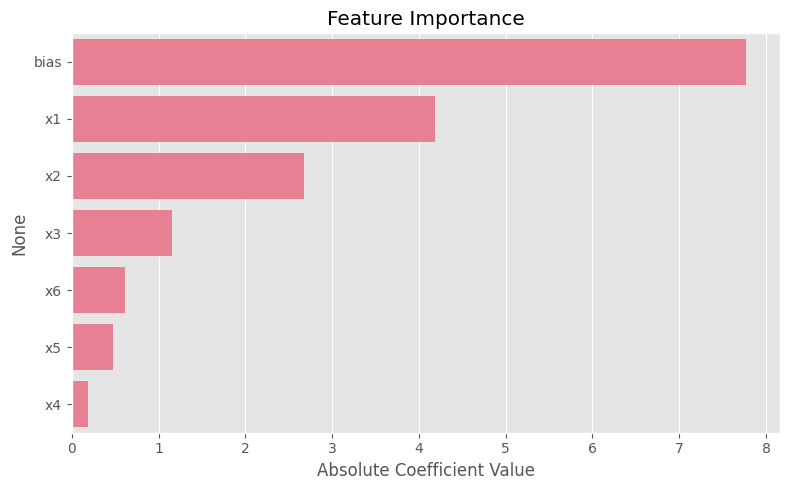

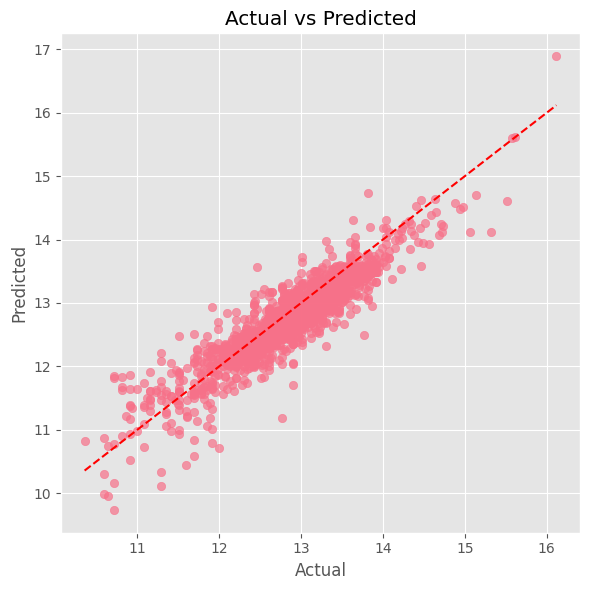

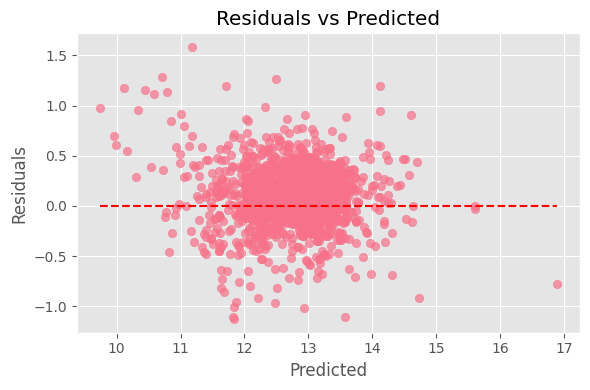

🏃 View run Lasso_Init_xavier at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/d65e81d15c054966838541ffa2709490
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.109238, r2=0.803434


init_method       mse        r2
0      xavier  0.109238  0.803434
1       zeros  0.158467  0.714849

In [49]:
import pandas as pd
from copy import deepcopy

# -------------------------
# Comparison: Lasso with different initializations
# -------------------------
init_methods = ["zeros", "xavier"]
fixed_params = {
    "degree": 1,
    "method": "sto",
    "lr": 0.01,
    "use_momentum": True,
    "momentum": 0.9  # ignored since use_momentum=False
}

results_inits = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for init_method in init_methods:
    print(f"\n🚀 Running Lasso with init_method={init_method}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Lasso",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=init_method,
            lr=fixed_params["lr"],
            use_momentum=fixed_params["use_momentum"],
            momentum=fixed_params["momentum"],
            run_name=f"Lasso_Init_{init_method}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_inits.append({
            "init_method": init_method,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for init_method={init_method}: {e}")
        results_inits.append({
            "init_method": init_method,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_inits = pd.DataFrame(results_inits).sort_values("r2", ascending=False)
df_inits.reset_index(drop=True, inplace=True)
df_inits



🚀 Running Lasso with lr=0.01
Fold 0: 0.11424790330252763
Fold 1: 0.11322501714318157
Fold 2: 0.12108203831070016
Test MSE: 0.11496477578060166, Test R2: 0.7931288684643419


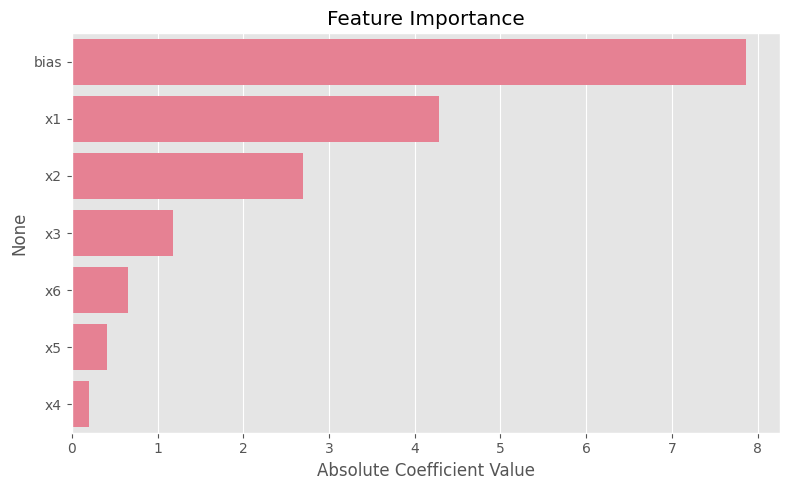

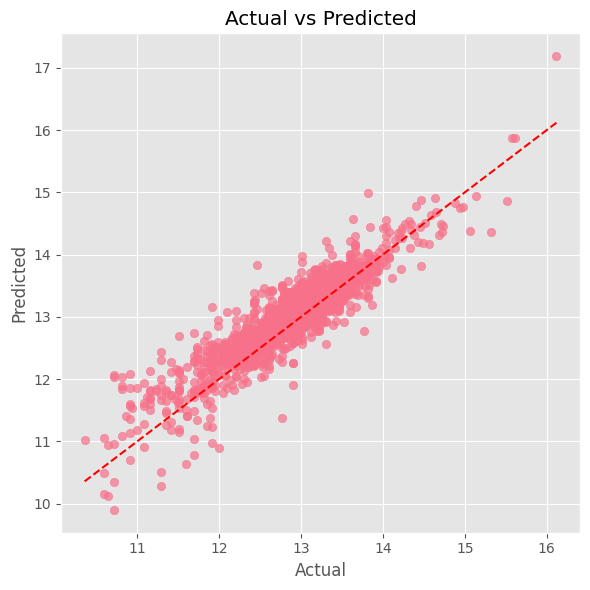

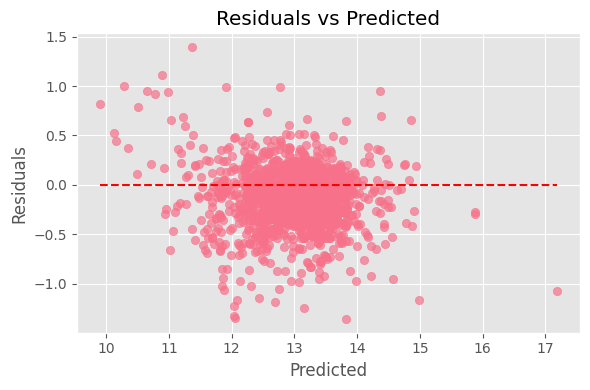

🏃 View run Lasso_lr_0.01 at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/39cfb7633db54a0491a4c1af905f3962
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.114965, r2=0.793129

🚀 Running Lasso with lr=0.001
Fold 0: 0.12347701997600206
Fold 1: 0.09974699369943735
Fold 2: 0.10708844735548649
Test MSE: 0.09913564350543475, Test R2: 0.8216122929111533


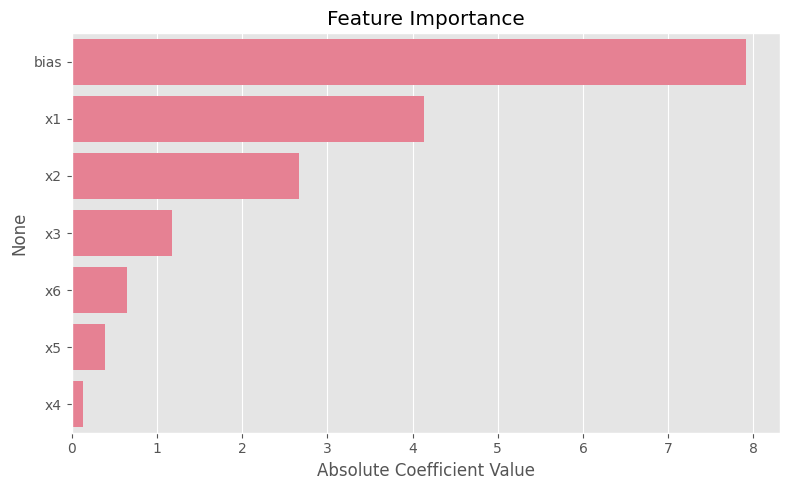

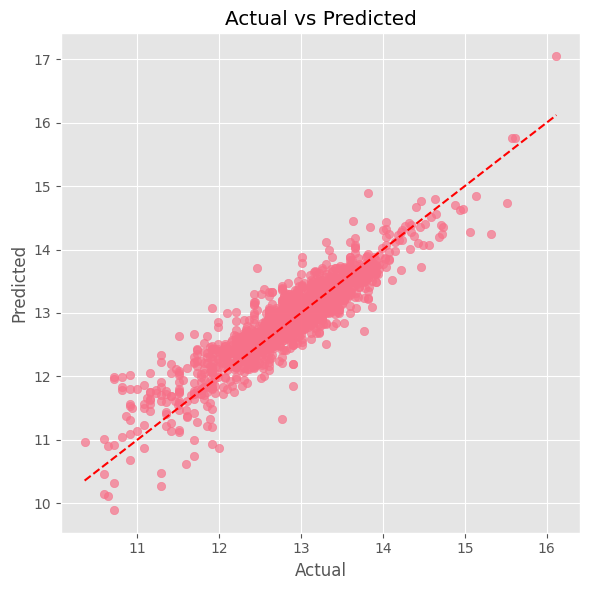

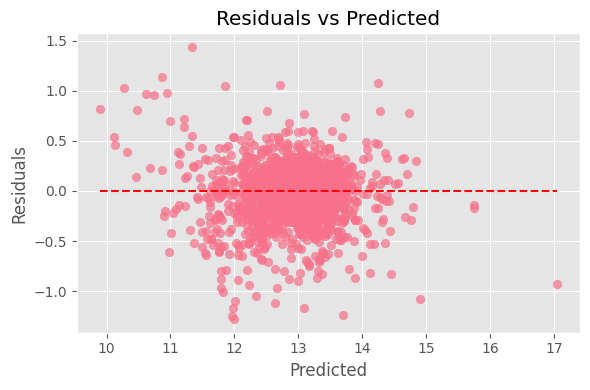

🏃 View run Lasso_lr_0.001 at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/fa2dcadee6564627b7814bf1a075af5c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.099136, r2=0.821612

🚀 Running Lasso with lr=0.0001
Fold 0: 0.115666100648613
Fold 1: 0.10314865309469728
Fold 2: 0.1090979908358928
Test MSE: 0.10179326491376894, Test R2: 0.8168300877165406


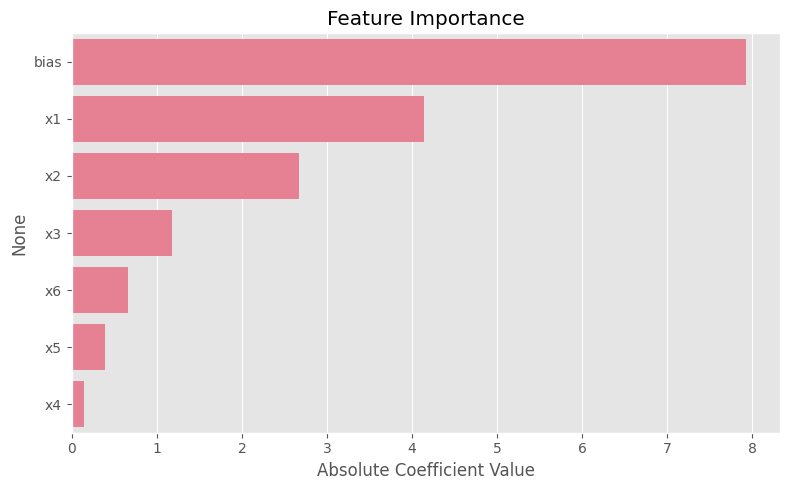

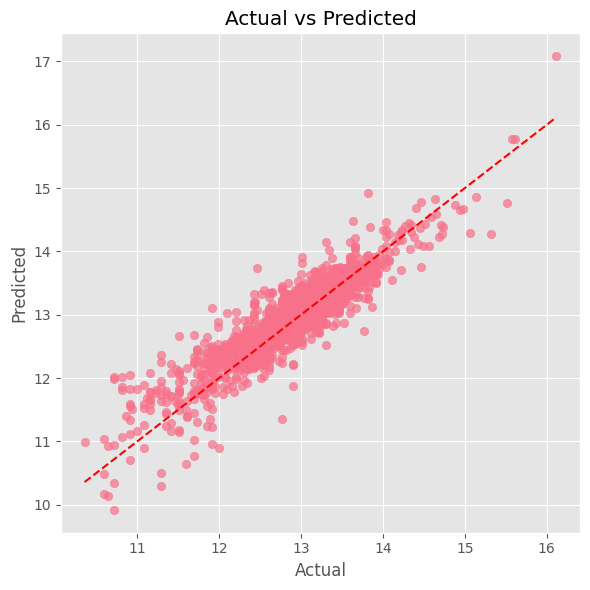

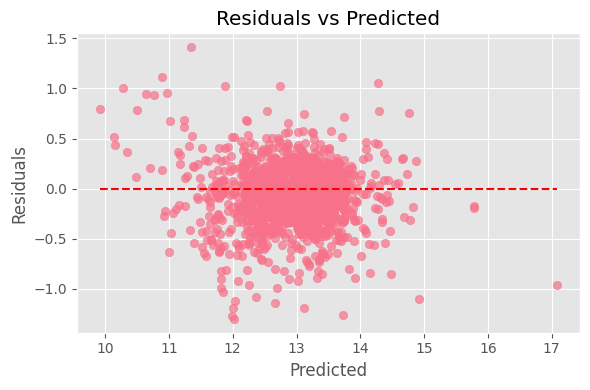

🏃 View run Lasso_lr_0.0001 at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/5142dcd157614beb8fe49550cbd5db8b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798
mse=0.101793, r2=0.816830


learning_rate       mse        r2
0         0.0010  0.099136  0.821612
1         0.0001  0.101793  0.816830
2         0.0100  0.114965  0.793129

In [50]:
import numpy as np
import pandas as pd
from copy import deepcopy

# -------------------------
# Comparison: Lasso, sto, xavier, different learning rates
# -------------------------
learning_rates = [0.01, 0.001, 0.0001]
fixed_params = {
    "degree": 1,
    "method": "sto",
    "init_method": "xavier",
    "use_momentum": True,
    "momentum": 0.9  # ignored since use_momentum=False
}

results_lr = []

# Use deep copies to preserve original data
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)
X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

for lr in learning_rates:
    print(f"\n🚀 Running Lasso with lr={lr}")

    try:
        # Run experiment once on full training and test data
        result = run_experiment(
            model_class="Lasso",
            X_train=X_train_copy,
            y_train=y_train_copy,
            X_test=X_test_copy,
            y_test=y_test_copy,
            degree=fixed_params["degree"],
            method=fixed_params["method"],
            init_method=fixed_params["init_method"],
            lr=lr,
            use_momentum=fixed_params["use_momentum"],
            momentum=fixed_params["momentum"],
            run_name=f"Lasso_lr_{lr}"
        )

        mse = result["mse"]
        r2 = result["r2"]
        print(f"mse={mse:.6f}, r2={r2:.6f}")

        results_lr.append({
            "learning_rate": lr,
            "mse": mse,
            "r2": r2
        })

    except Exception as e:
        print(f"❌ Experiment failed for lr={lr}: {e}")
        results_lr.append({
            "learning_rate": lr,
            "mse": None,
            "r2": None
        })

# Final comparison table
df_lr = pd.DataFrame(results_lr).sort_values("r2", ascending=False)
df_lr.reset_index(drop=True, inplace=True)
df_lr


Fold 0: 0.11992636775744564
Fold 1: 0.1057196027097368
Fold 2: 0.10797394284845063
Test MSE: 0.10027302560755826, Test R2: 0.819565652791542


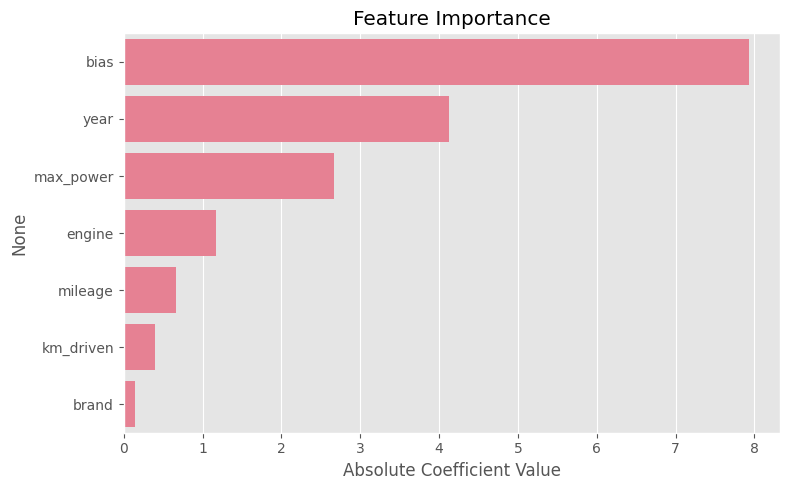

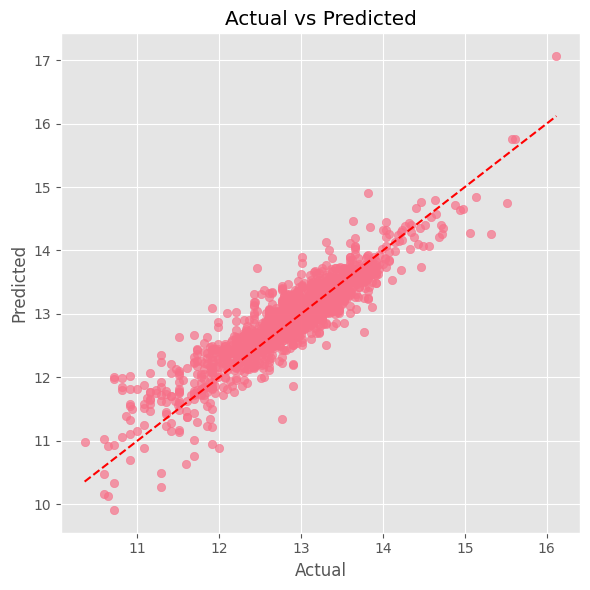

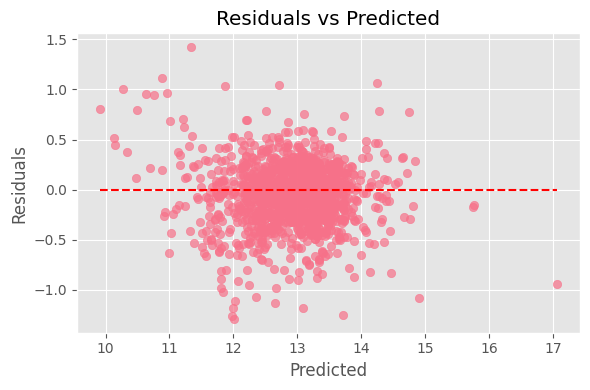

🏃 View run final at: http://127.0.0.1:5000/#/experiments/839360960728144798/runs/97fec2bd19c446f8869b86a50dc9faa5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/839360960728144798


In [51]:
result = run_experiment(
    model_class='Lasso',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    method='sto',
    lr=0.001,
    init_method='xavier',
    use_momentum=True,
    polynomial=True,
    degree=1,
    run_name="final"
)

model = result["model"]

In [ ]:
import pickle

model_data = {
    'model': model,
    'feature_cols': model.feature_cols,
    'le_dict': model.label_encoders  # categorical encoders
}

with open('app/model/custom_car_price_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved successfully")


In [ ]:
def predict_car_price(input_data, model_data):
    model = model_data['model']
    le_dict = model_data['le_dict']
    feature_cols = model_data['feature_cols']

    processed = []
    for col in feature_cols:
        if col in le_dict:
            try:
                processed.append(le_dict[col].transform([input_data[col]])[0])
            except ValueError:
                processed.append(0)
        else:
            processed.append(input_data[col])

    sample = np.array(processed).reshape(1, -1)
    # Predict log price
    pred_log_price = model.predict(pd.DataFrame(sample, columns=feature_cols))[0]
    # Convert back to actual price
    pred_price = np.exp(pred_log_price)
    return pred_price


In [ ]:
example_car = {
    'year': 2014,
    'km_driven': 145500,
    'engine': 1248,
    'max_power': 74,
    'brand': 'Maruti',
    'mileage': 23.0
}

predicted_price = predict_car_price(example_car, model_data)
print(f"Predicted price: {predicted_price:,.0f}")


# Car Price Prediction: Analysis and Findings

## Introduction
This project aimed to **predict car prices** using regression models.  
Key steps included:
- Dataset preprocessing  
- Model training with multiple configurations  
- Experiment tracking via **MLflow**  
- Visual analysis with feature importance, residuals, and prediction plots  

---

## Dataset Preprocessing
We performed several preprocessing steps:

- **Owner mapping** → (e.g., *First Owner → 1, Second Owner → 2*).  
- **Removed CNG and LPG cars** (different mileage units: *km/kg vs kmpl*).  
- **Cleaned numeric columns** → stripped `"kmpl"` from mileage and `"CC"` from engine.  
- **Extracted brand** → first word from car name.  
- **Dropped torque** (inconsistent units).  
- **Removed Test Drive Cars** (unusually inflated prices).  
- **Log-transformed `selling_price`** to stabilize variation (range: 29,999 → 10,000,000).  

**Final dataset:** 6,827 entries, 12 columns, no missing values  

---

## Model Training & MLflow
- Experiments tracked under: **Car_Price_Regression_Experiments**  
- Example run ("Experiment1"):  
  - Model: **Ridge Regression**  
  - Optimization: **Stochastic**  
  - Learning rate: **0.01**  
  - Initialization: **Xavier**  
  - Polynomial degree: **1**  

**Outputs saved:** trained model, encoders, plots  

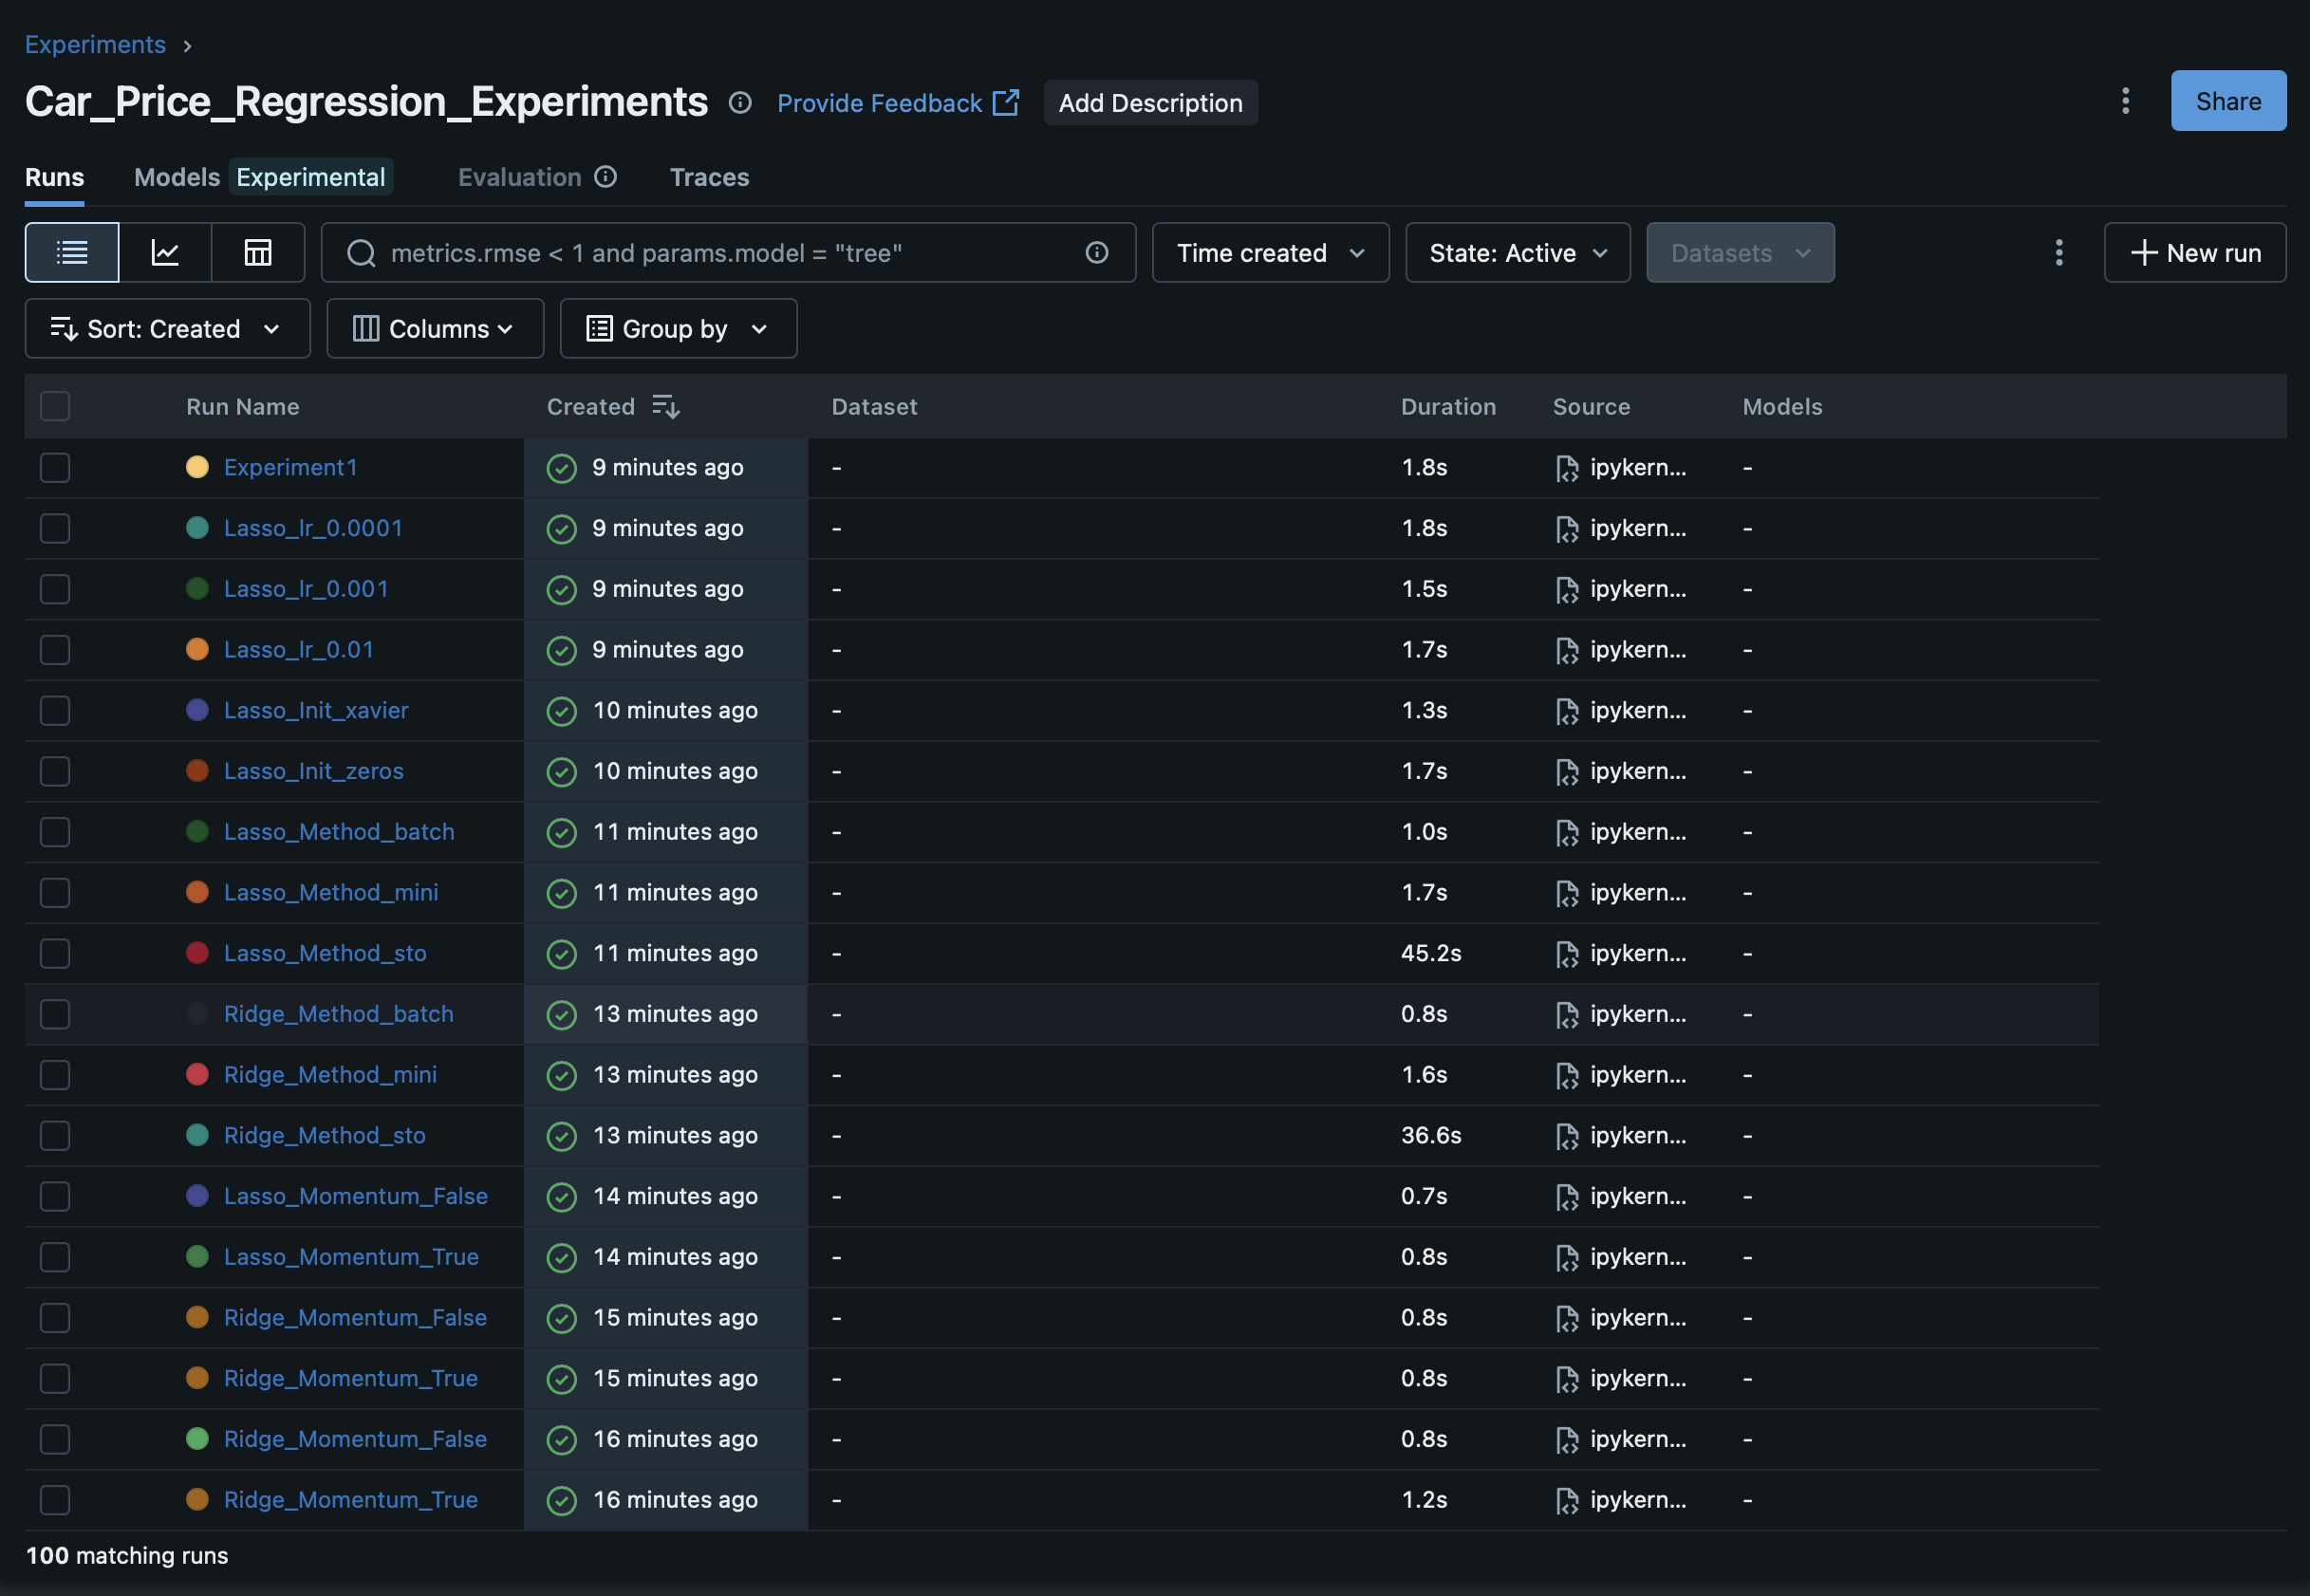

---

## Model Performance Example
- Car: **2014 Maruti**, 145,500 km, 1248 cc, 74 bhp, 23 kmpl  
- Predicted price: **≈ 399,509**  
- MLflow logged metrics and plots  

---

## Model Comparisons

### Model Types
| Model      | MSE   | R²     |
|------------|-------|--------|
| **Lasso**  | 0.158 | 0.716 |
| Ridge      | 0.16 | 0.712 |
| ElasticNet | 0.163 | 0.707 |
| Normal     | 0.162 | 0.708 |

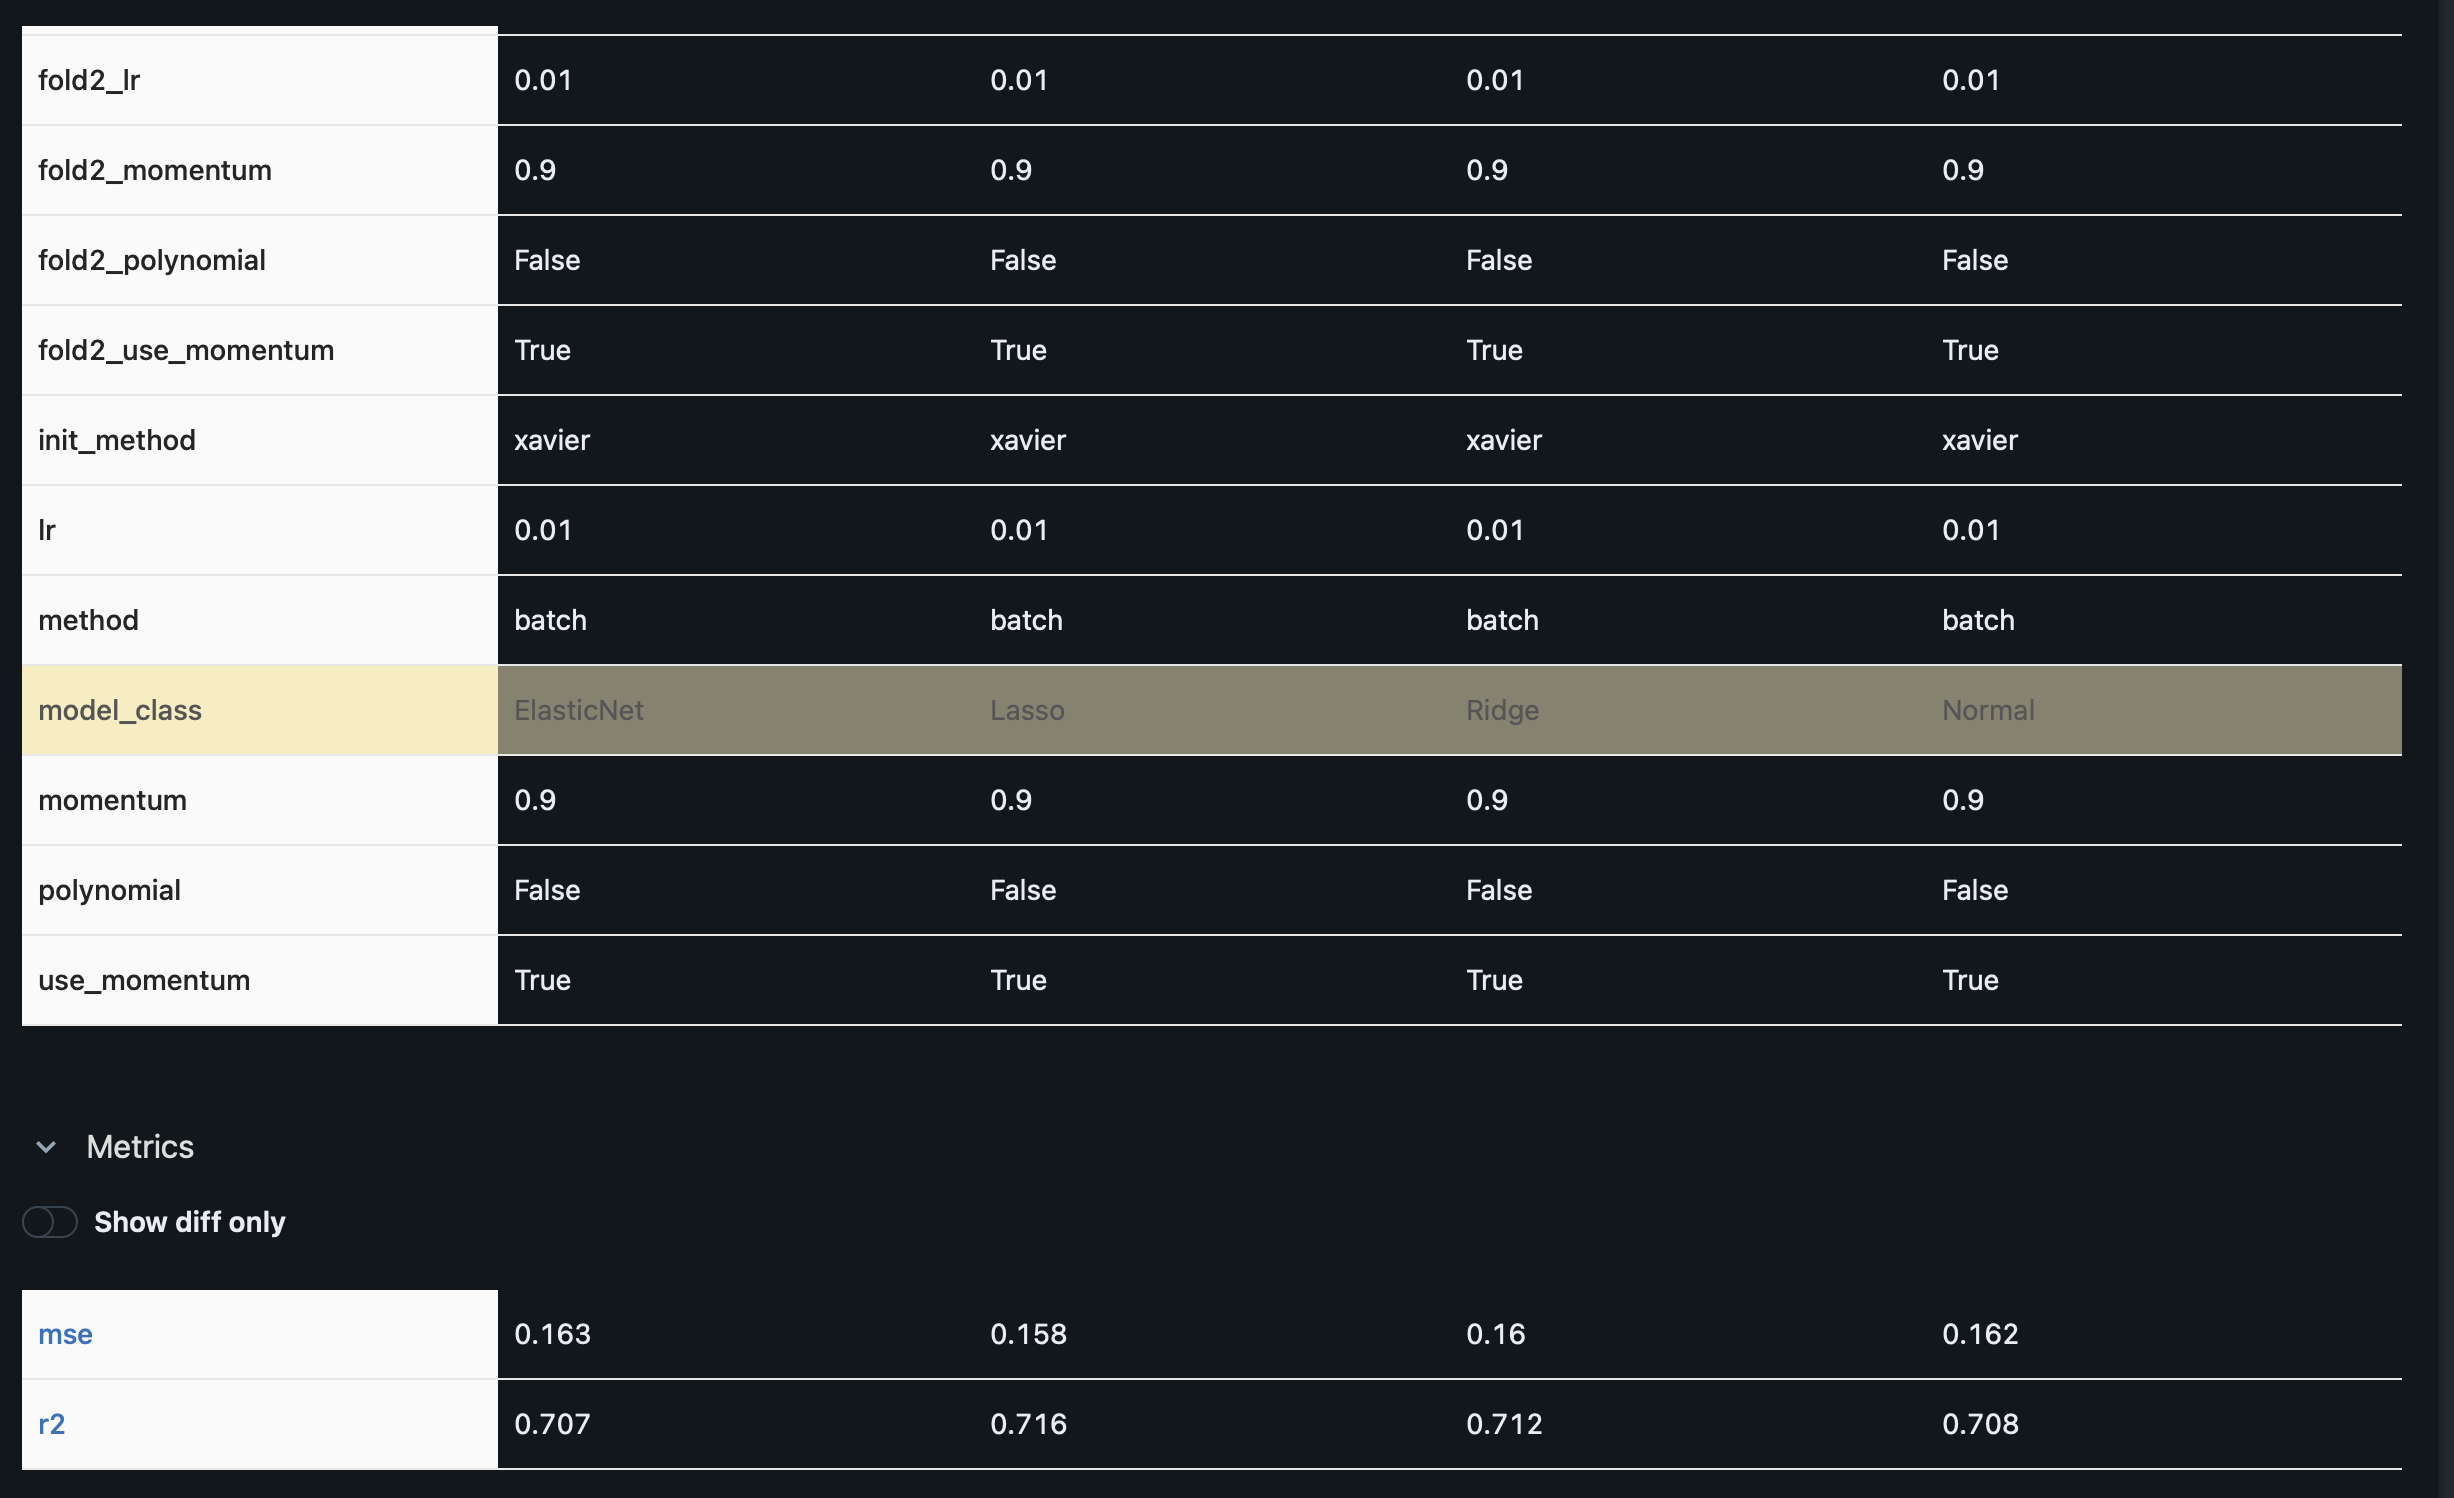
---

### Momentum
| Use Momentum | MSE   | R²     |
|--------------|-------|--------|
| True         | 0.159 | 0.713 |
| False        | 0.741 | -0.332 |

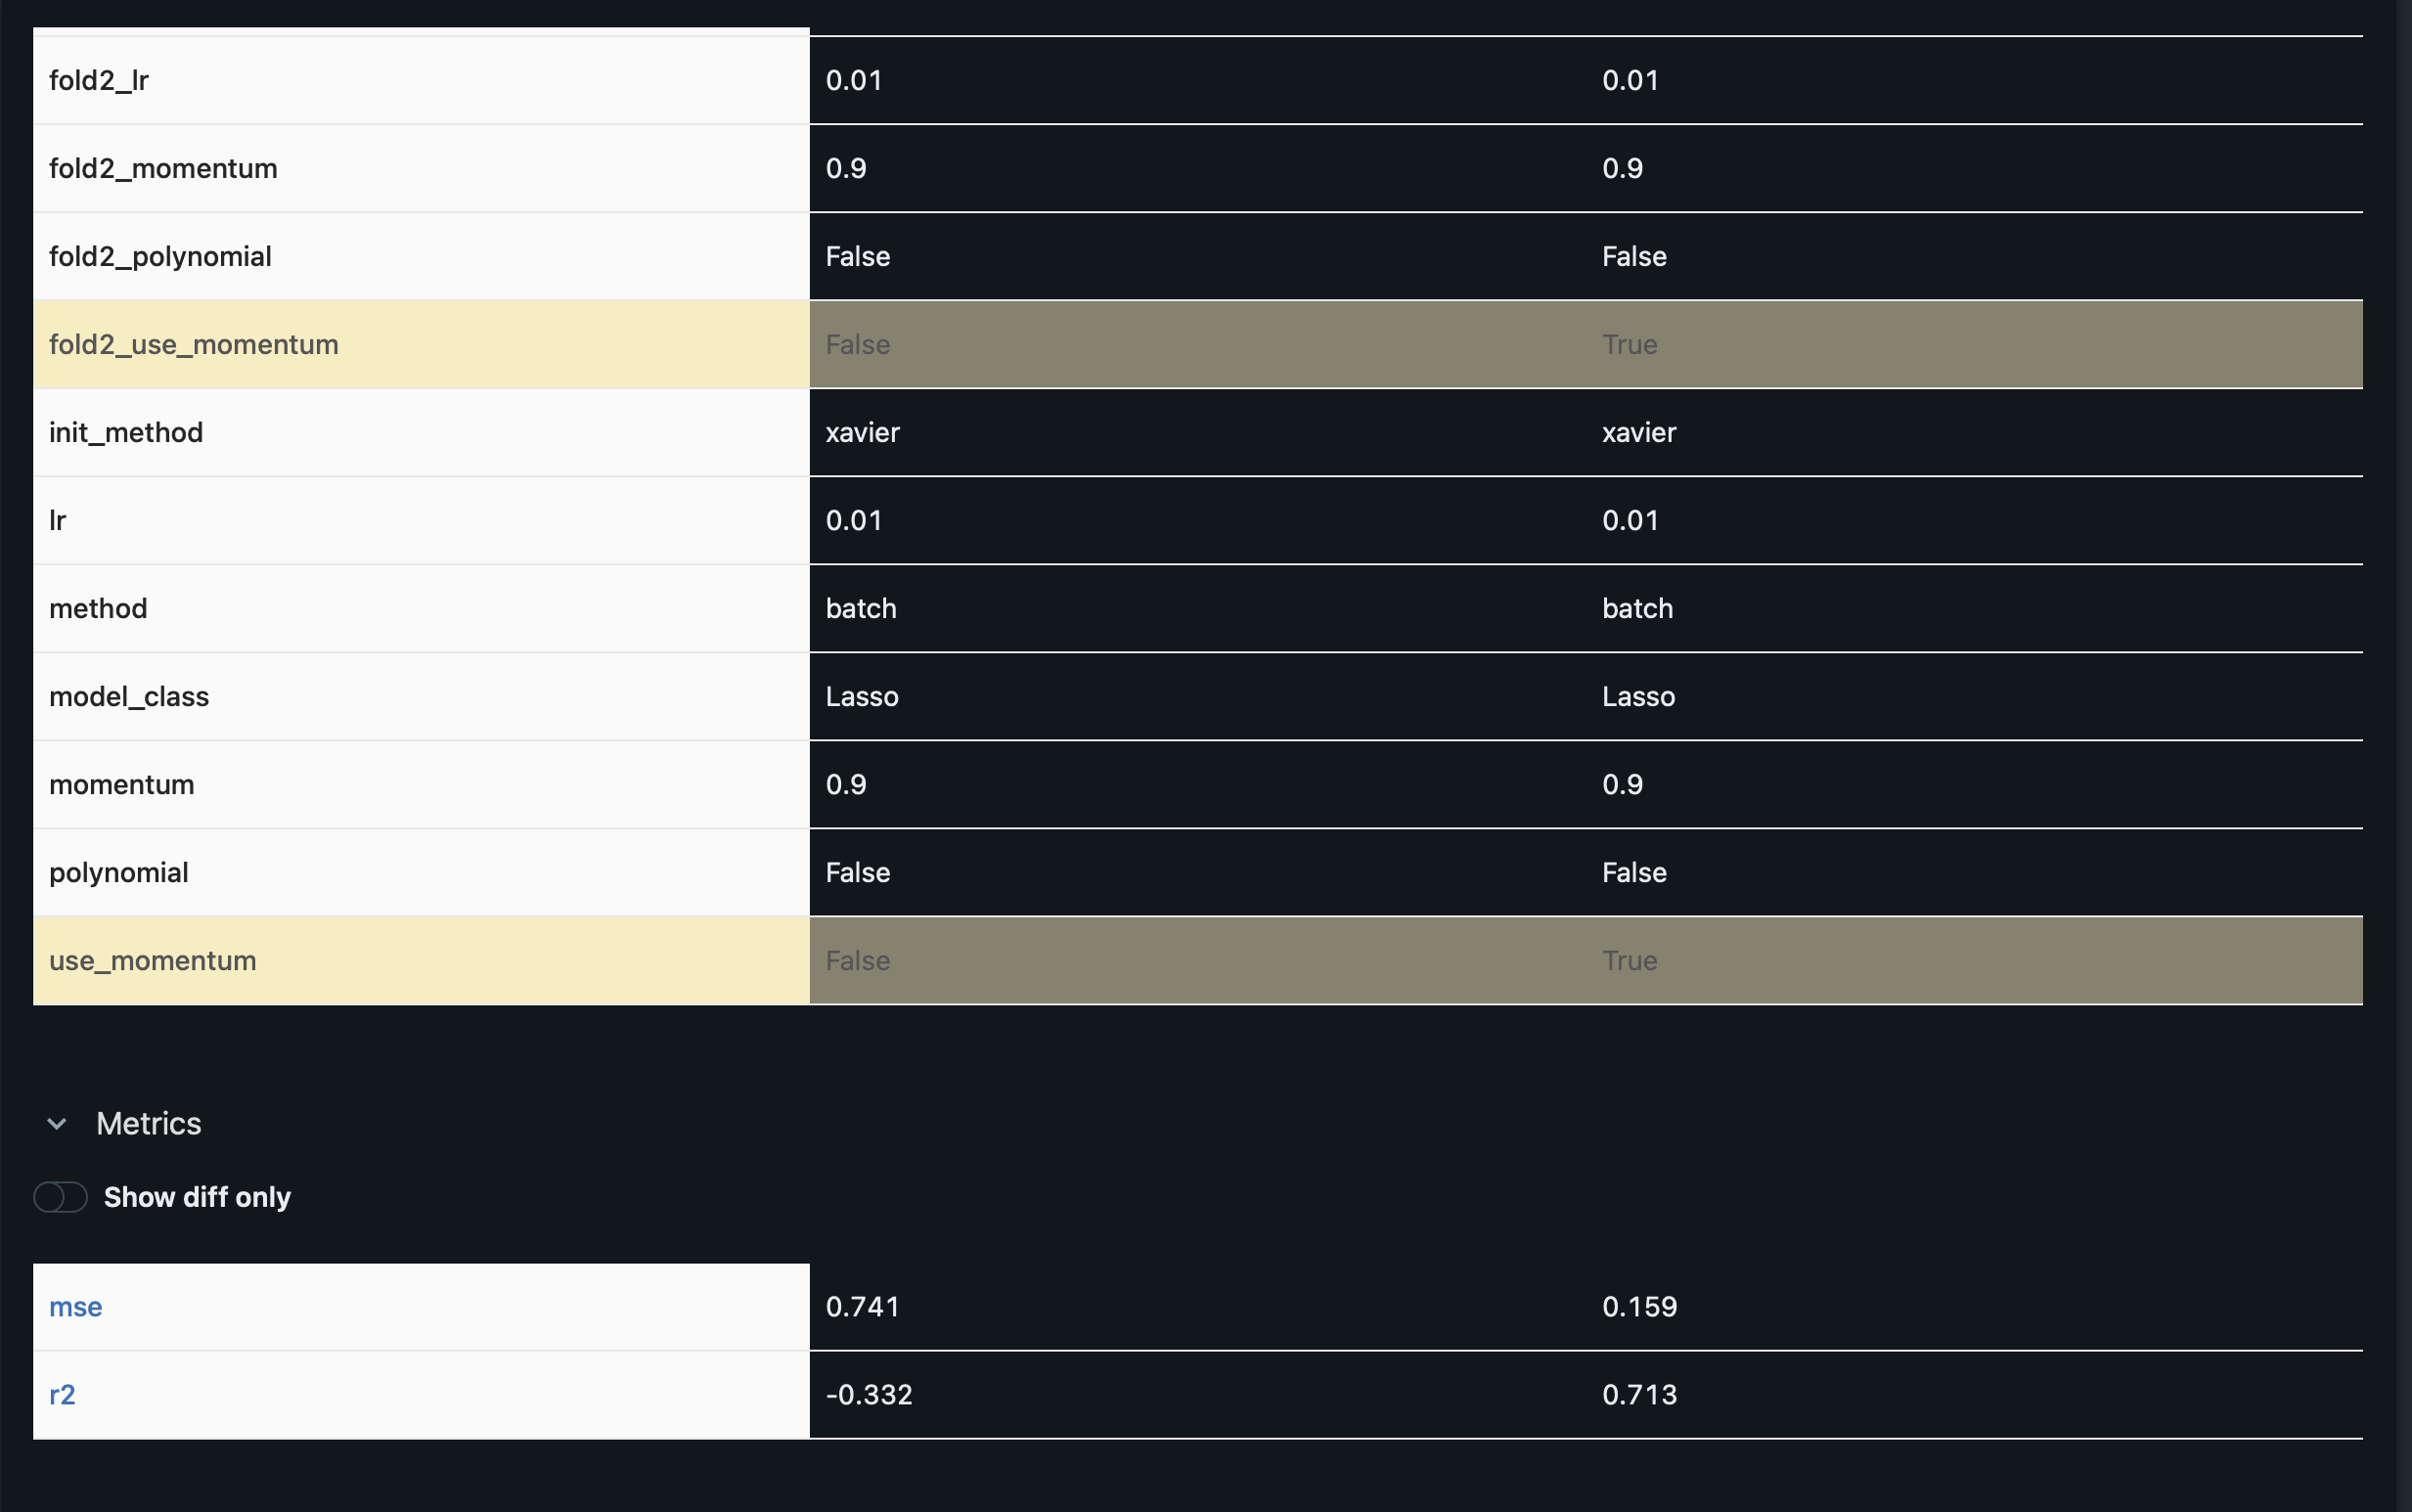
---

### Optimization Methods
| Method       | MSE   | R²     |
|--------------|-------|--------|
| Stochastic   | 0.099 | 0.823 |
| Mini-Batch   | 0.103 | 0.814 |
| Batch        | 0.153 | 0.725 |

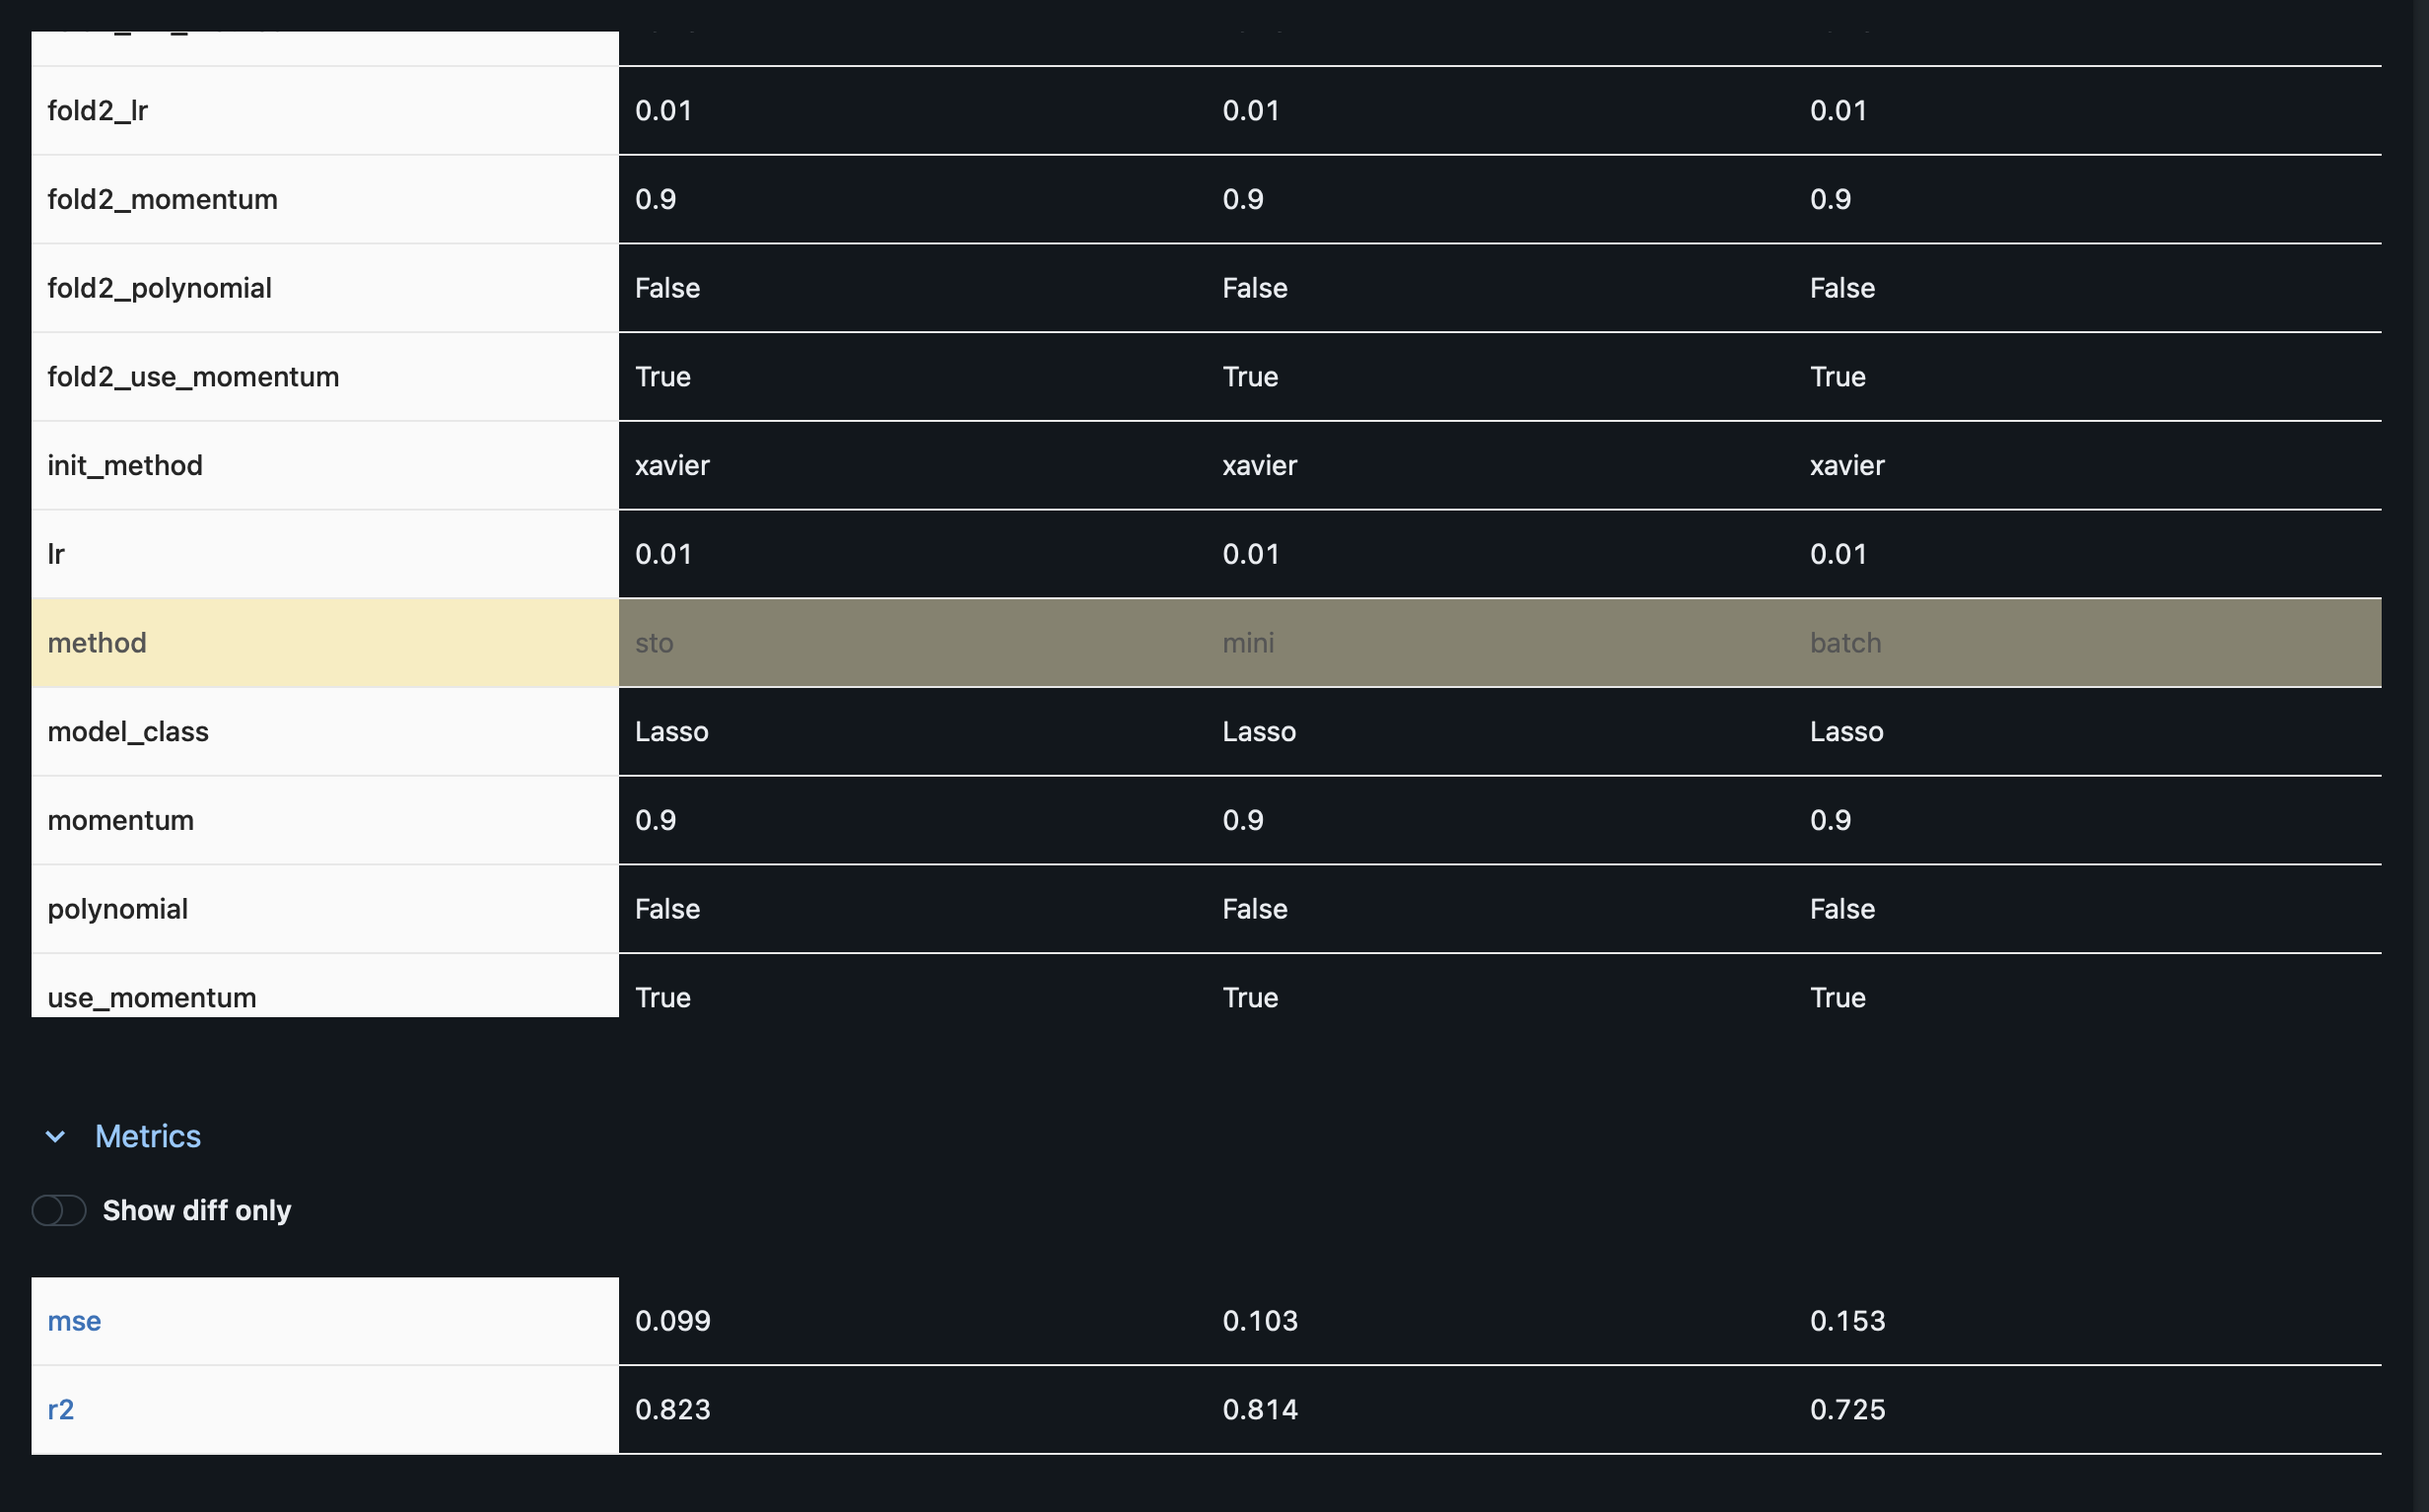
---

### Initialization
| Initialization | MSE   | R²     |
|----------------|-------|--------|
| Xavier         | 0.109 | 0.803 |
| Zero           | 0.158 | 0.715 |

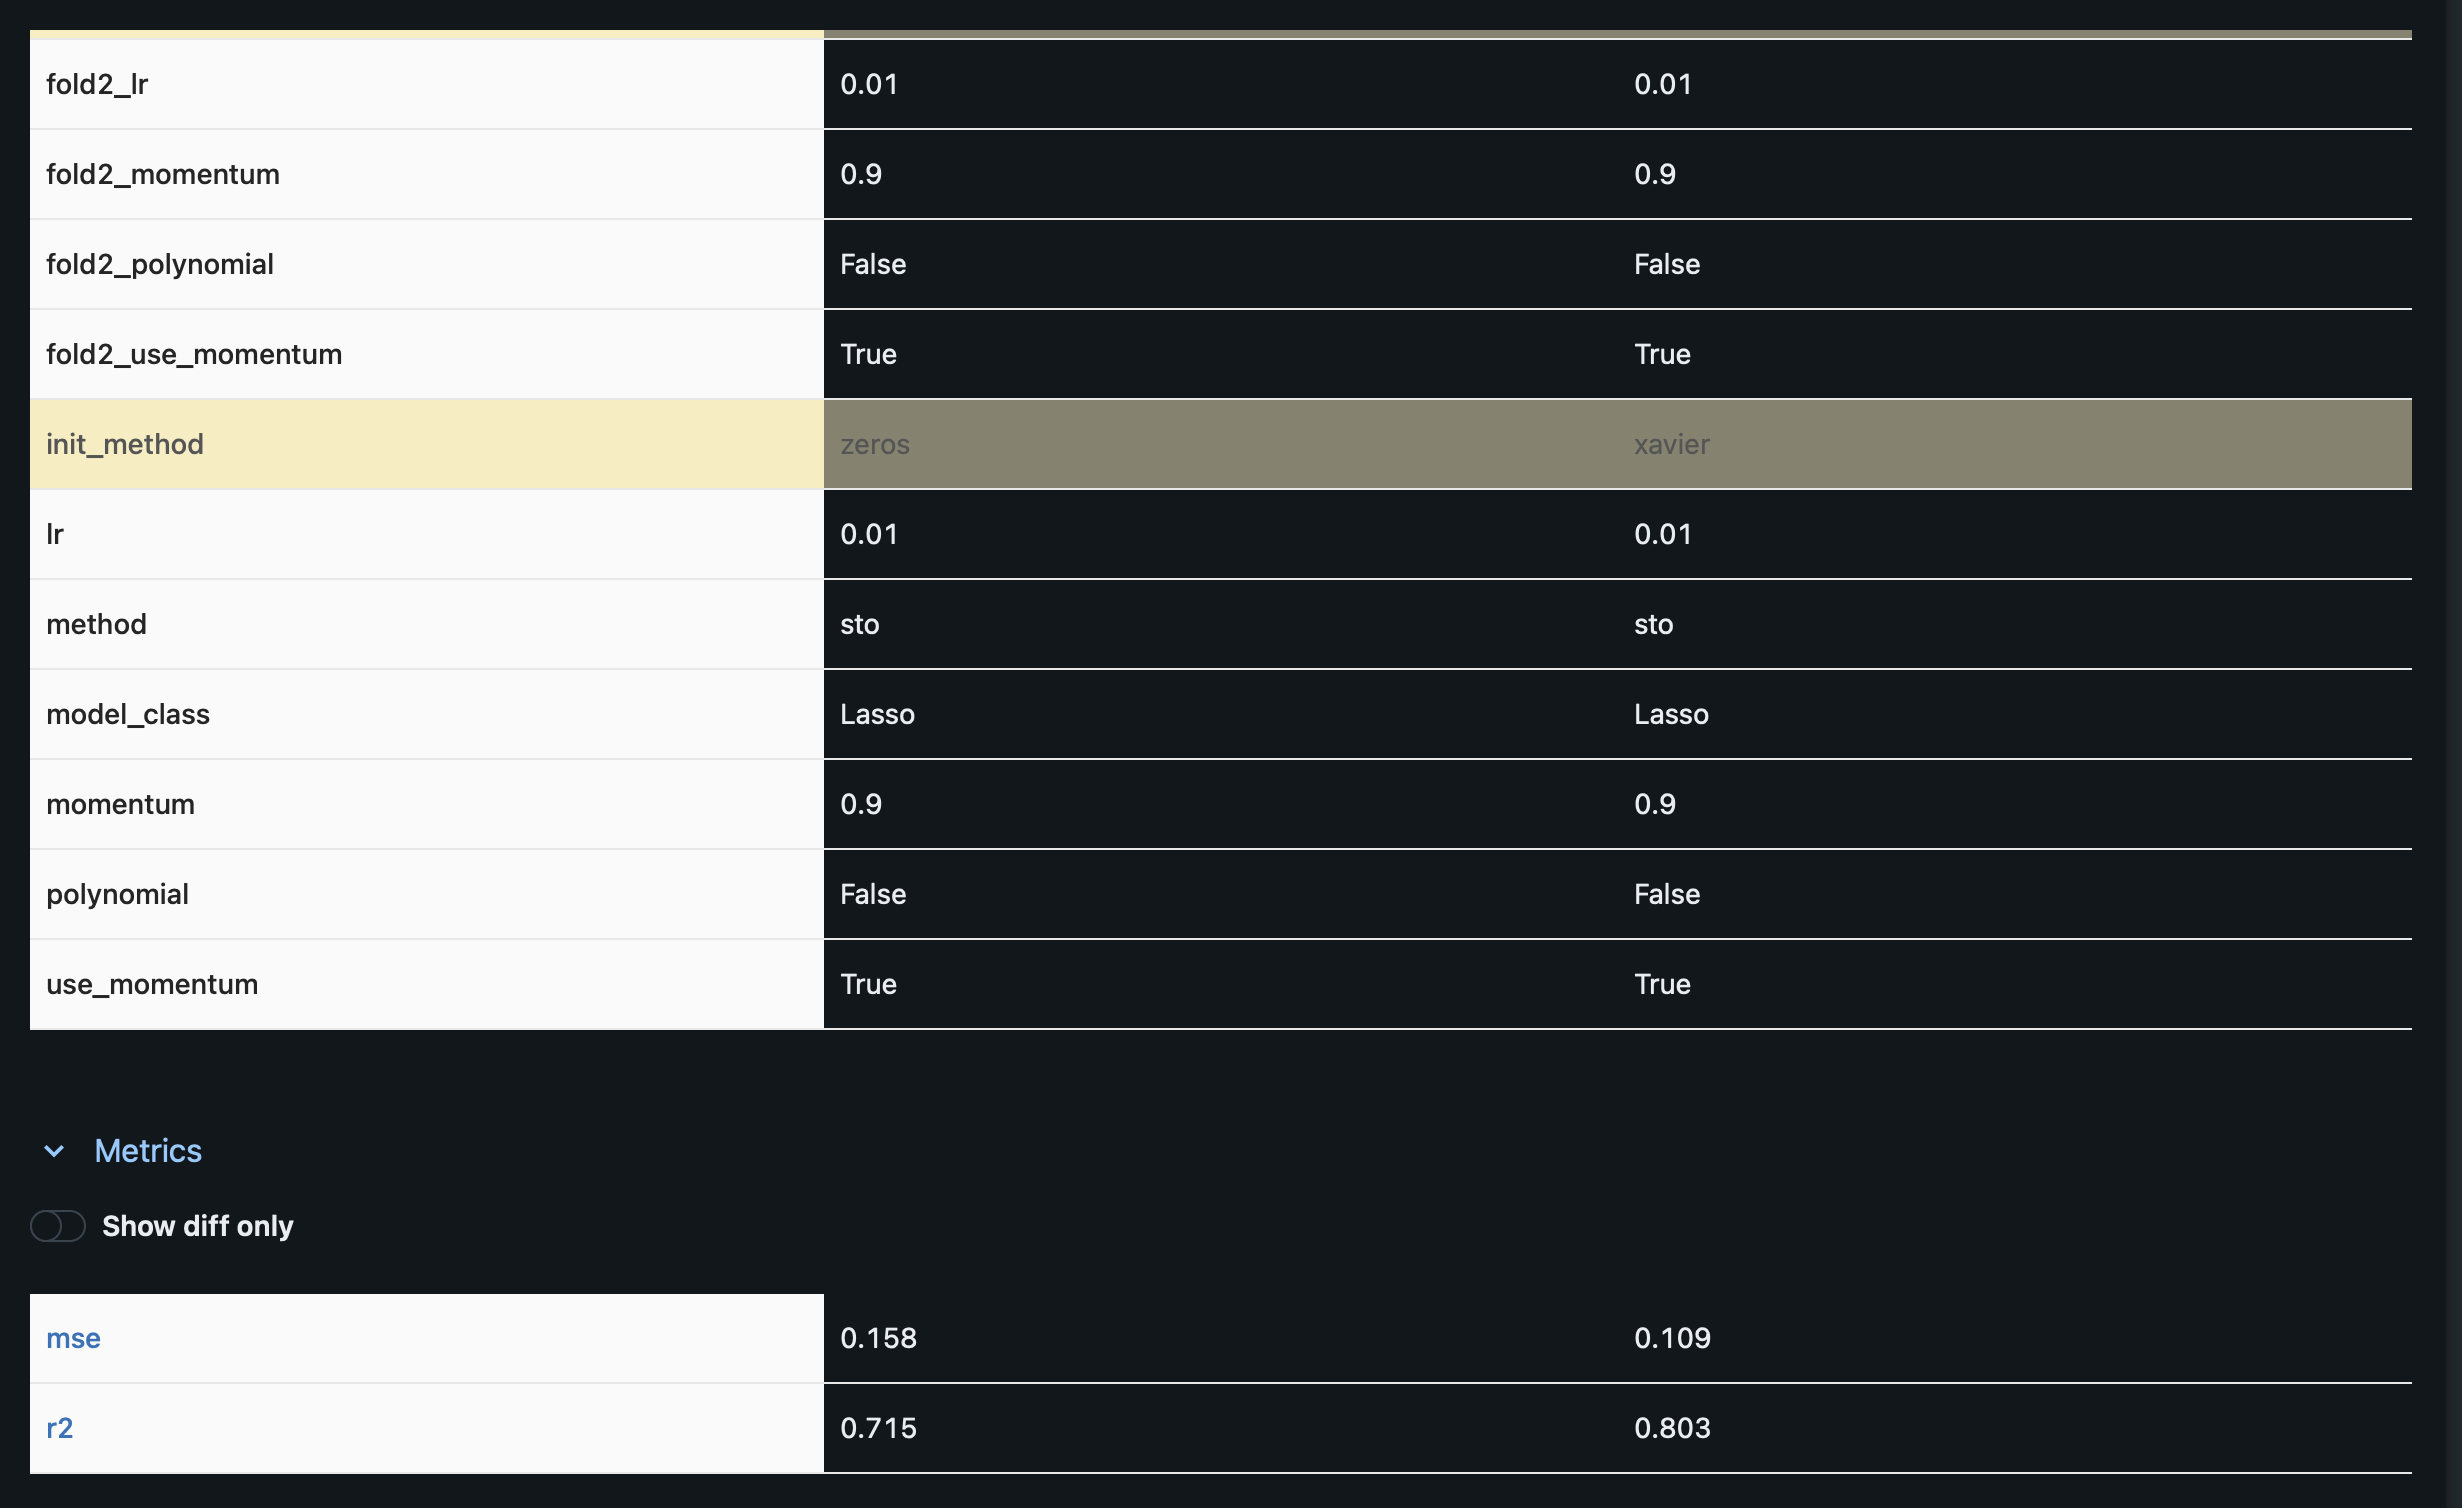
---

### Learning Rates
| LR     | MSE   | R²     |
|--------|-------|--------|
| 0.0010 | 0.099 | 0.822 |
| 0.0001 | 0.102 | 0.817 |
| 0.0100 | 0.115 | 0.793 |

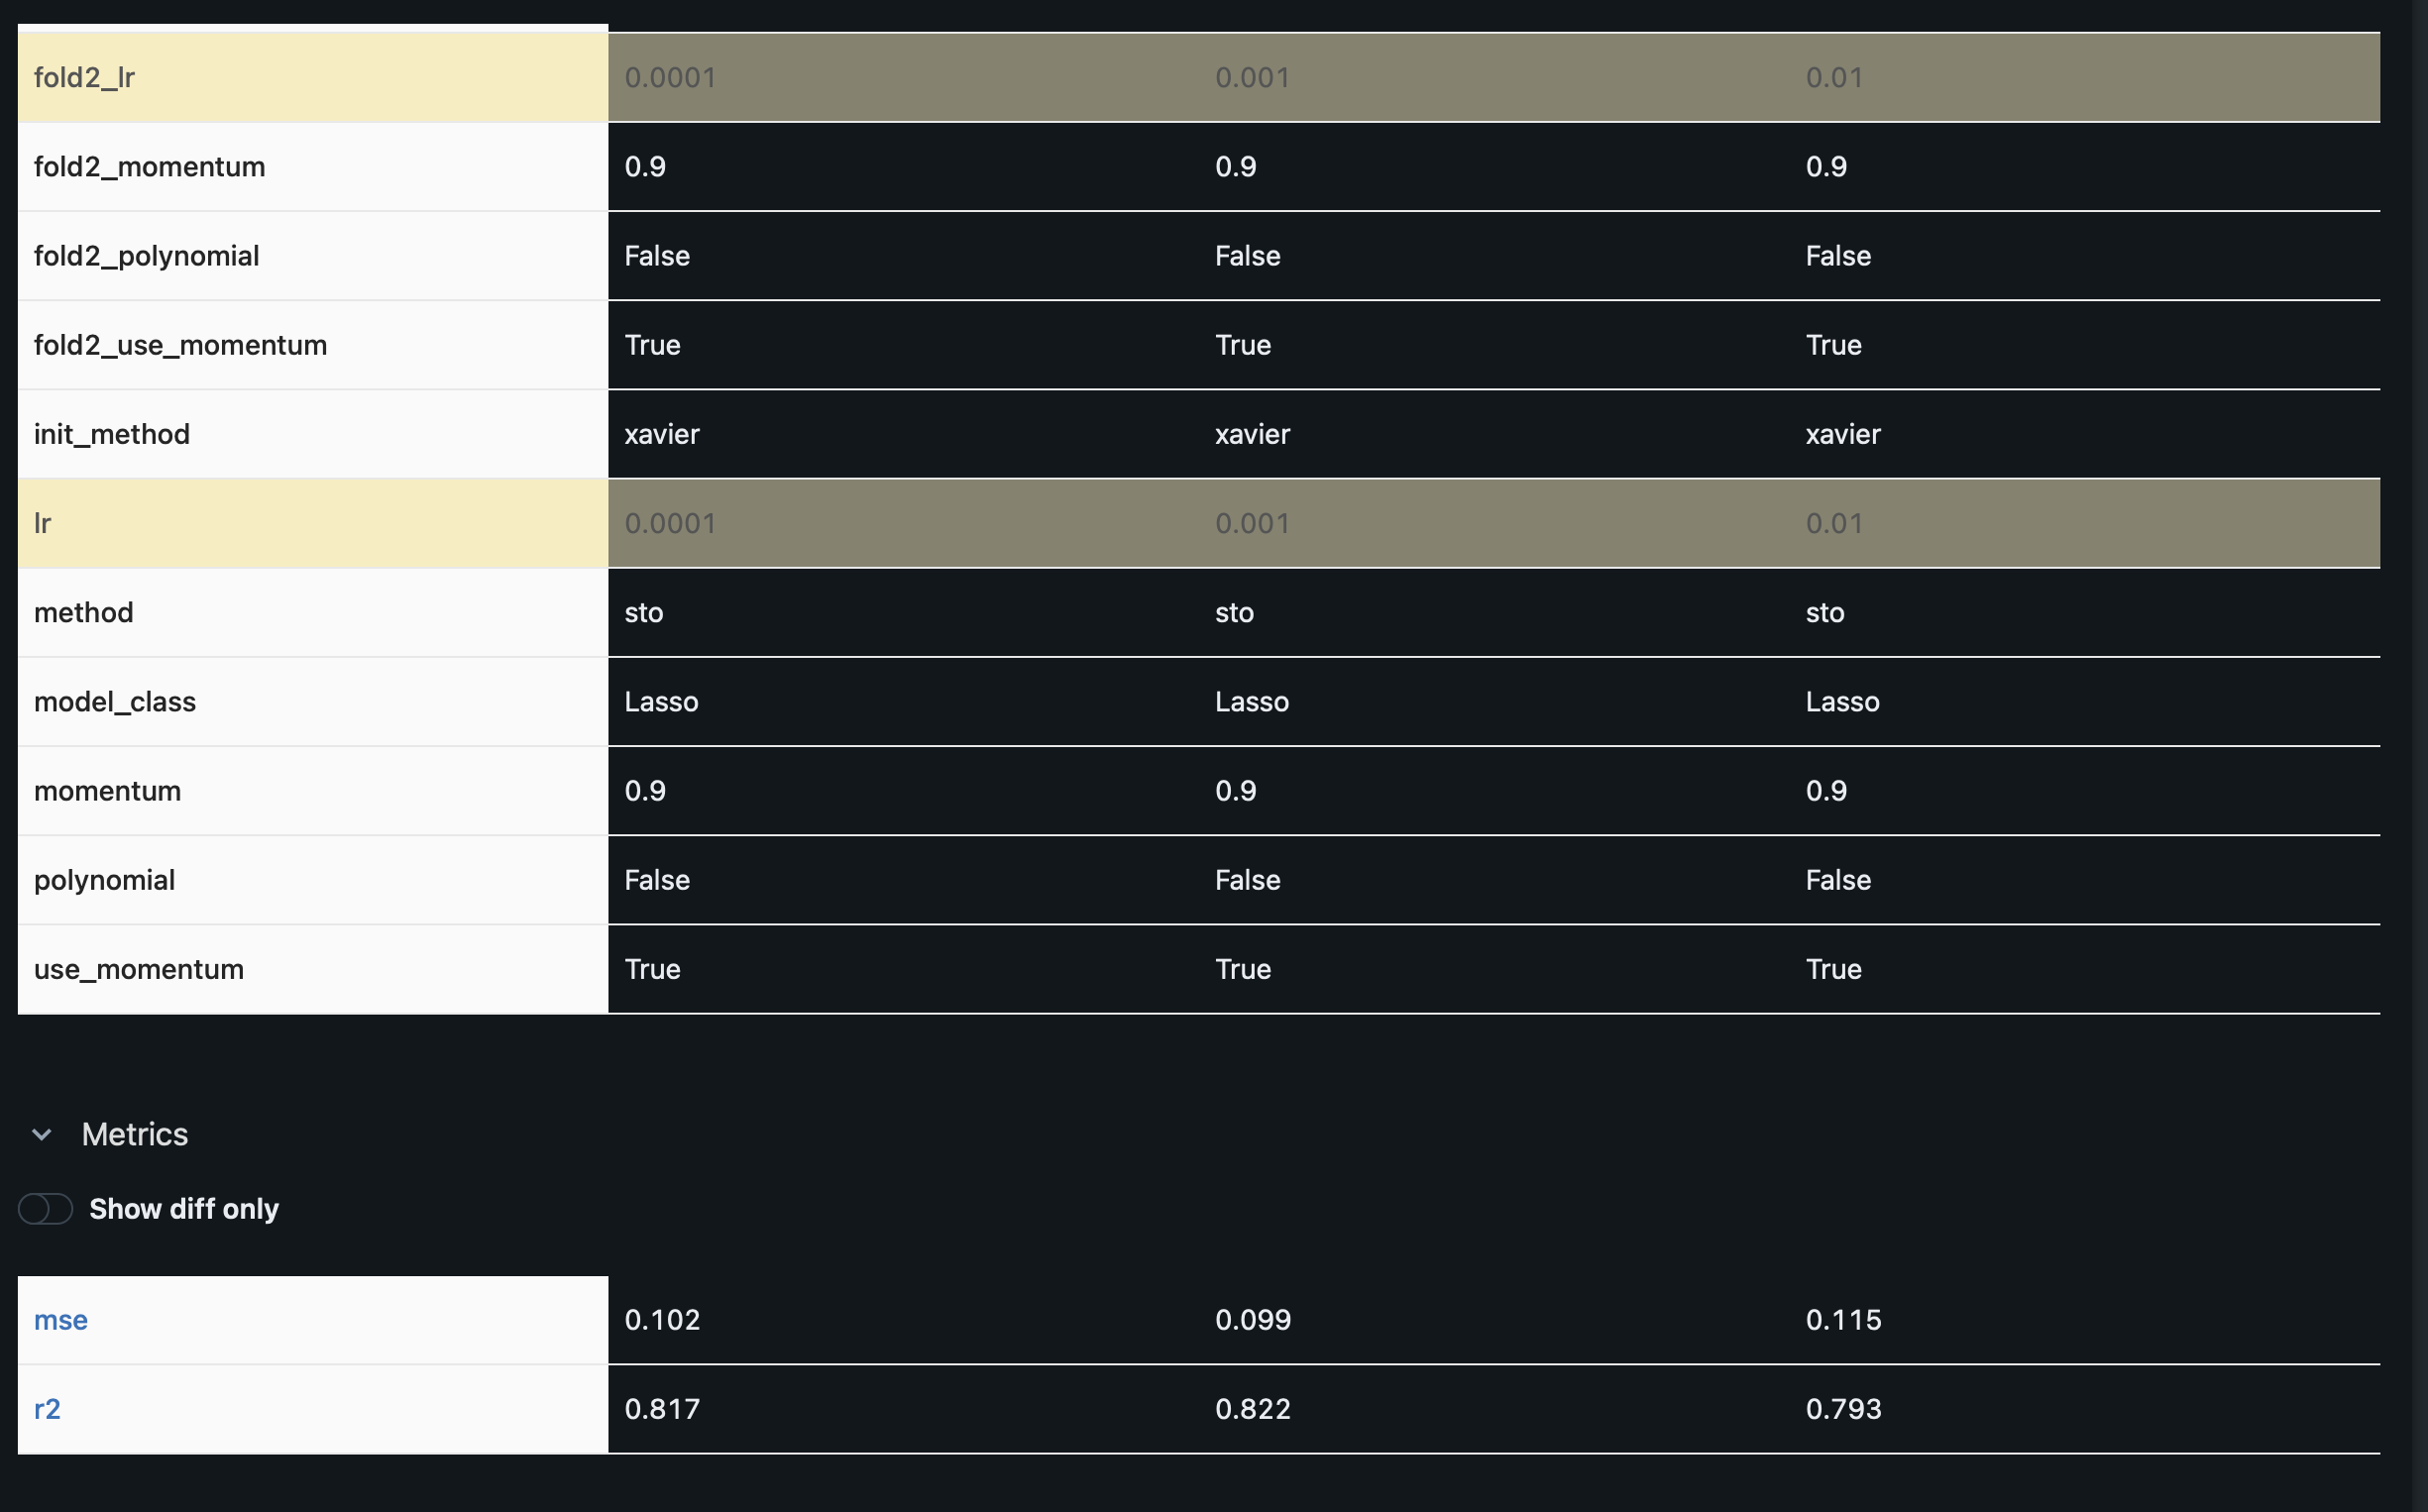
---

## Visual Analysis
For each configuration, three plots were generated:  

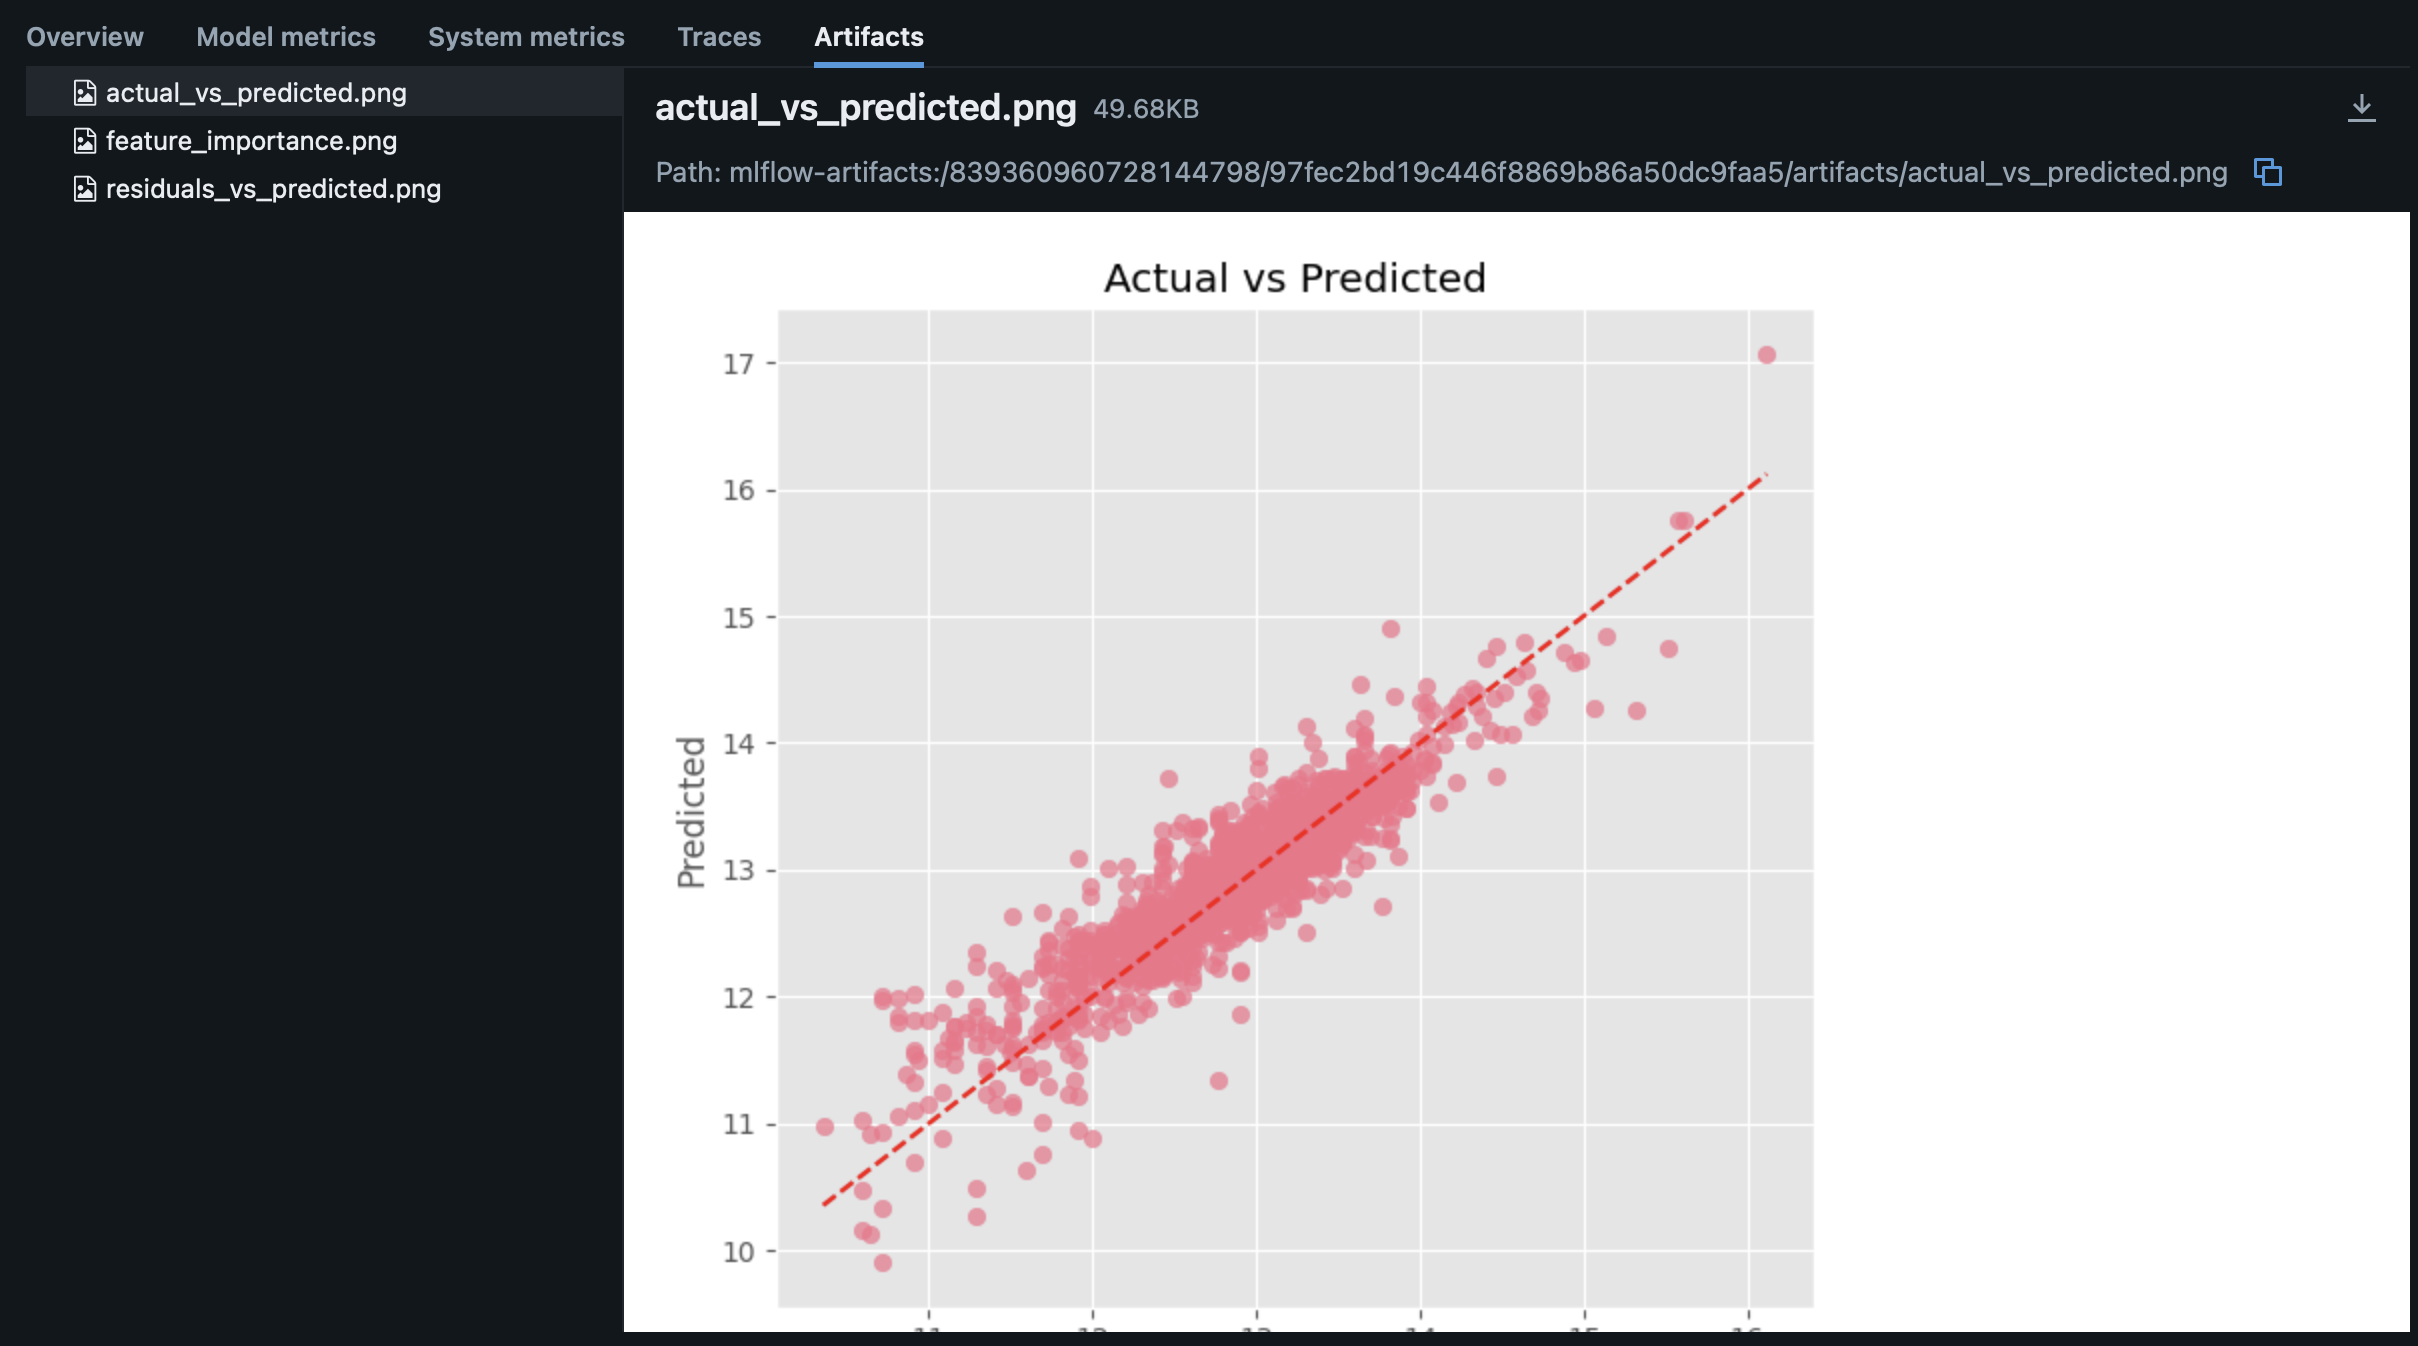
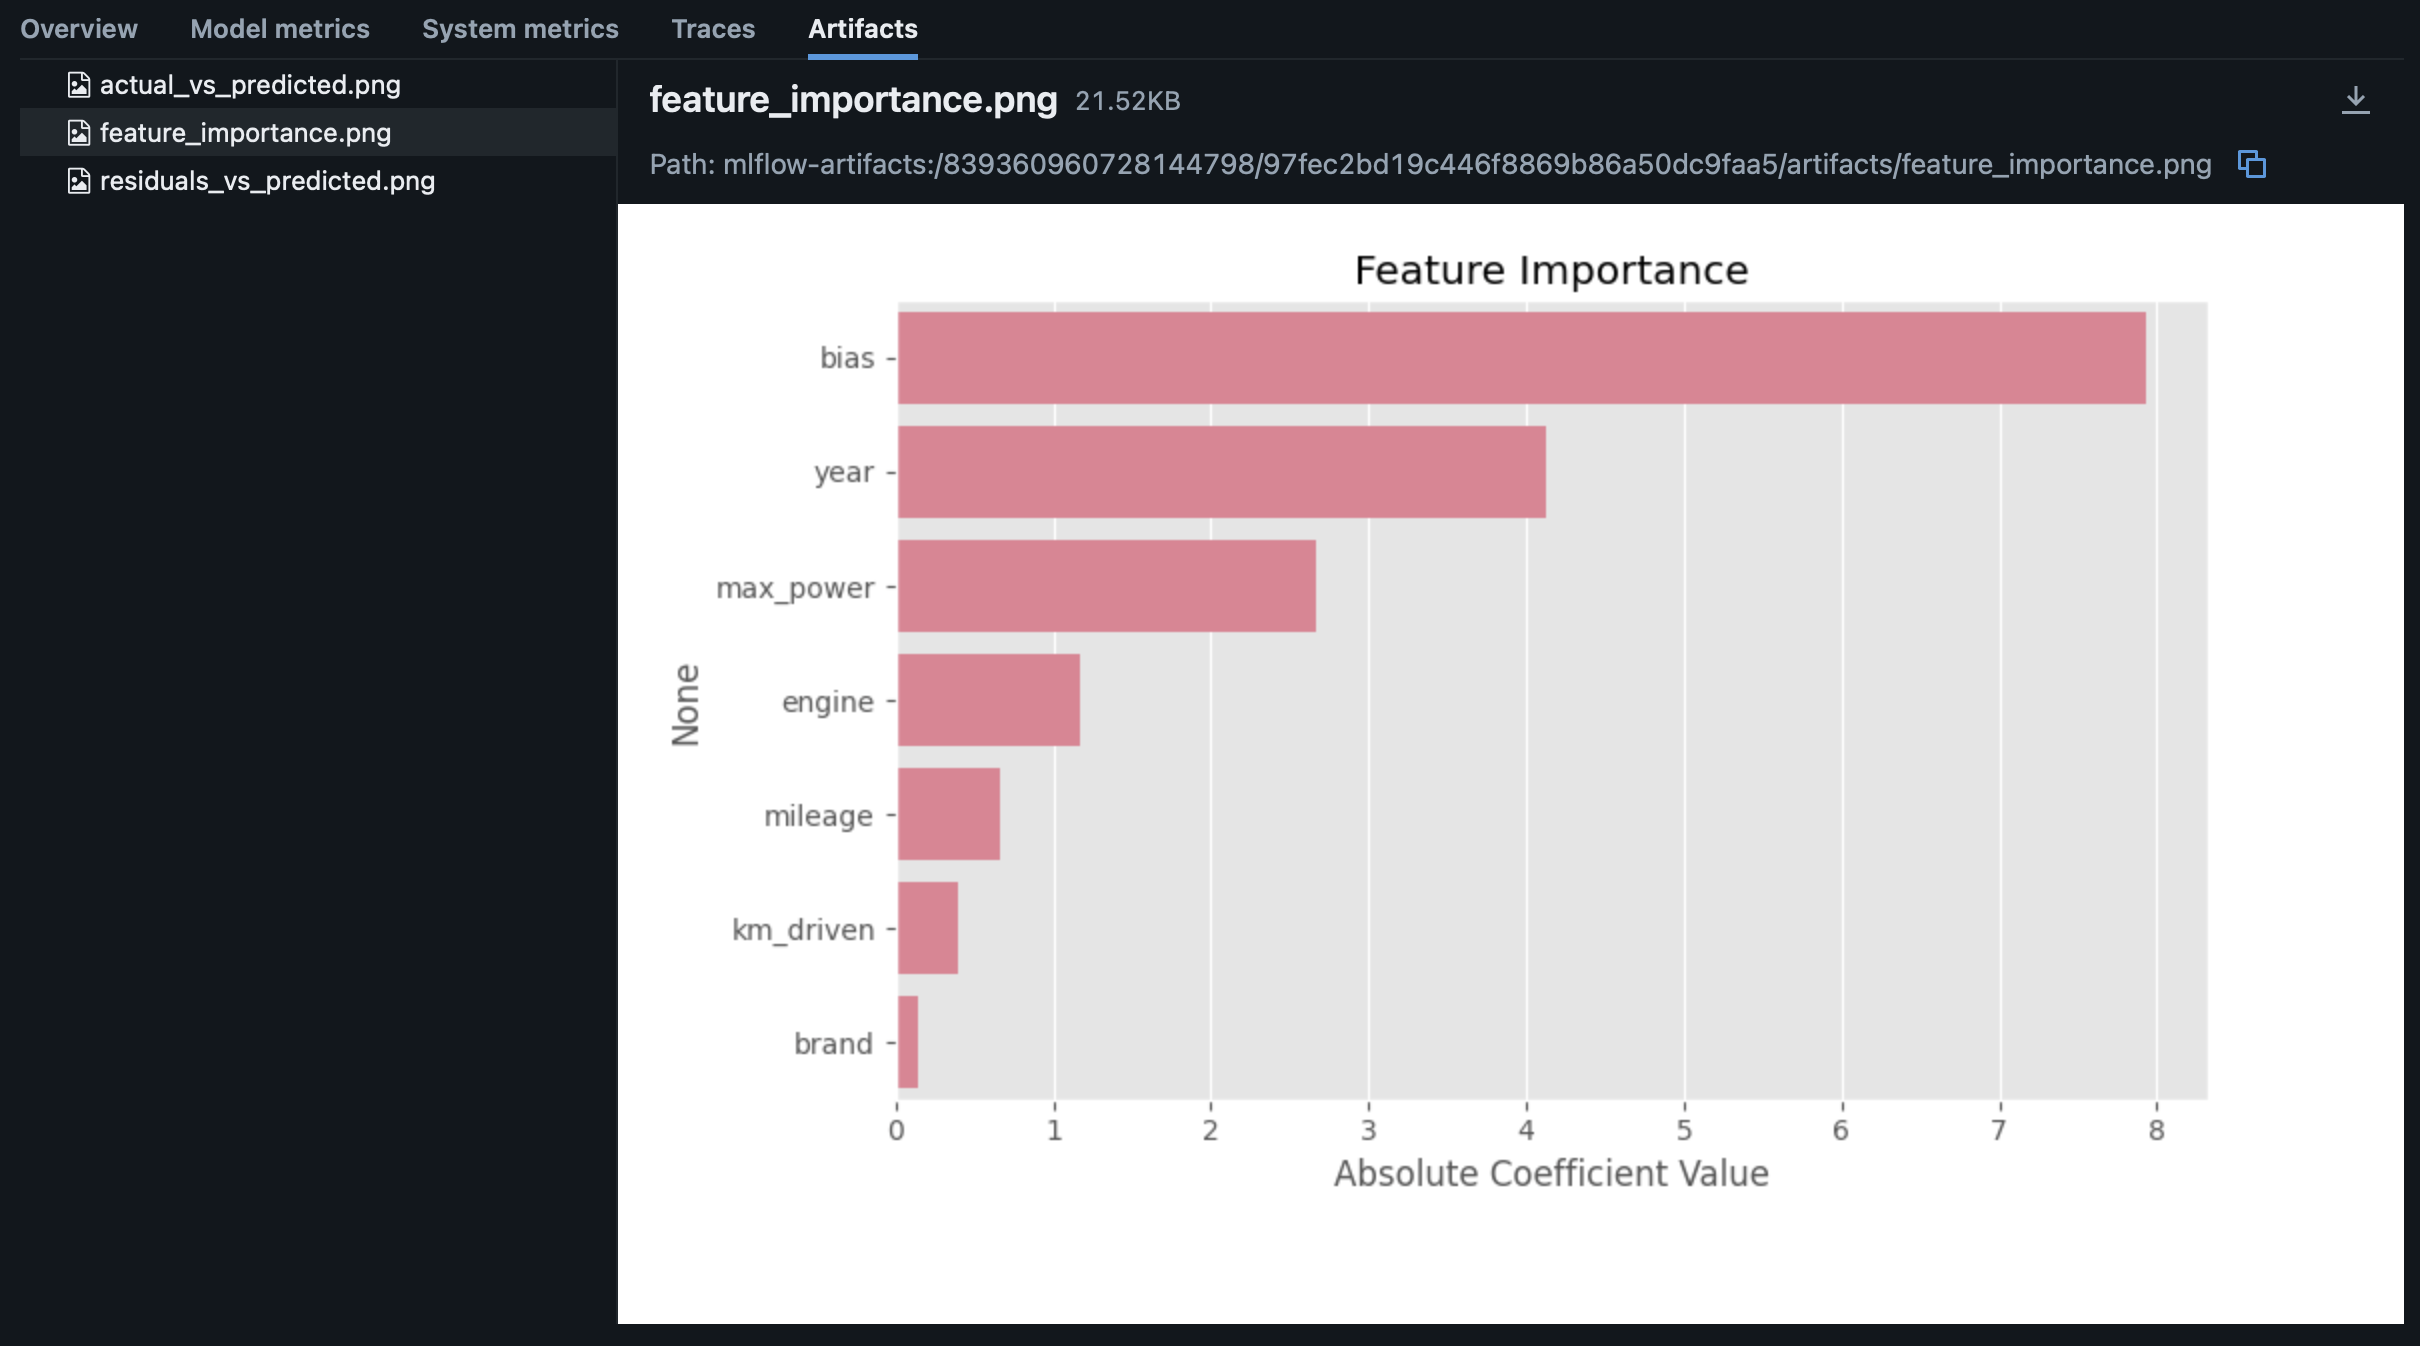
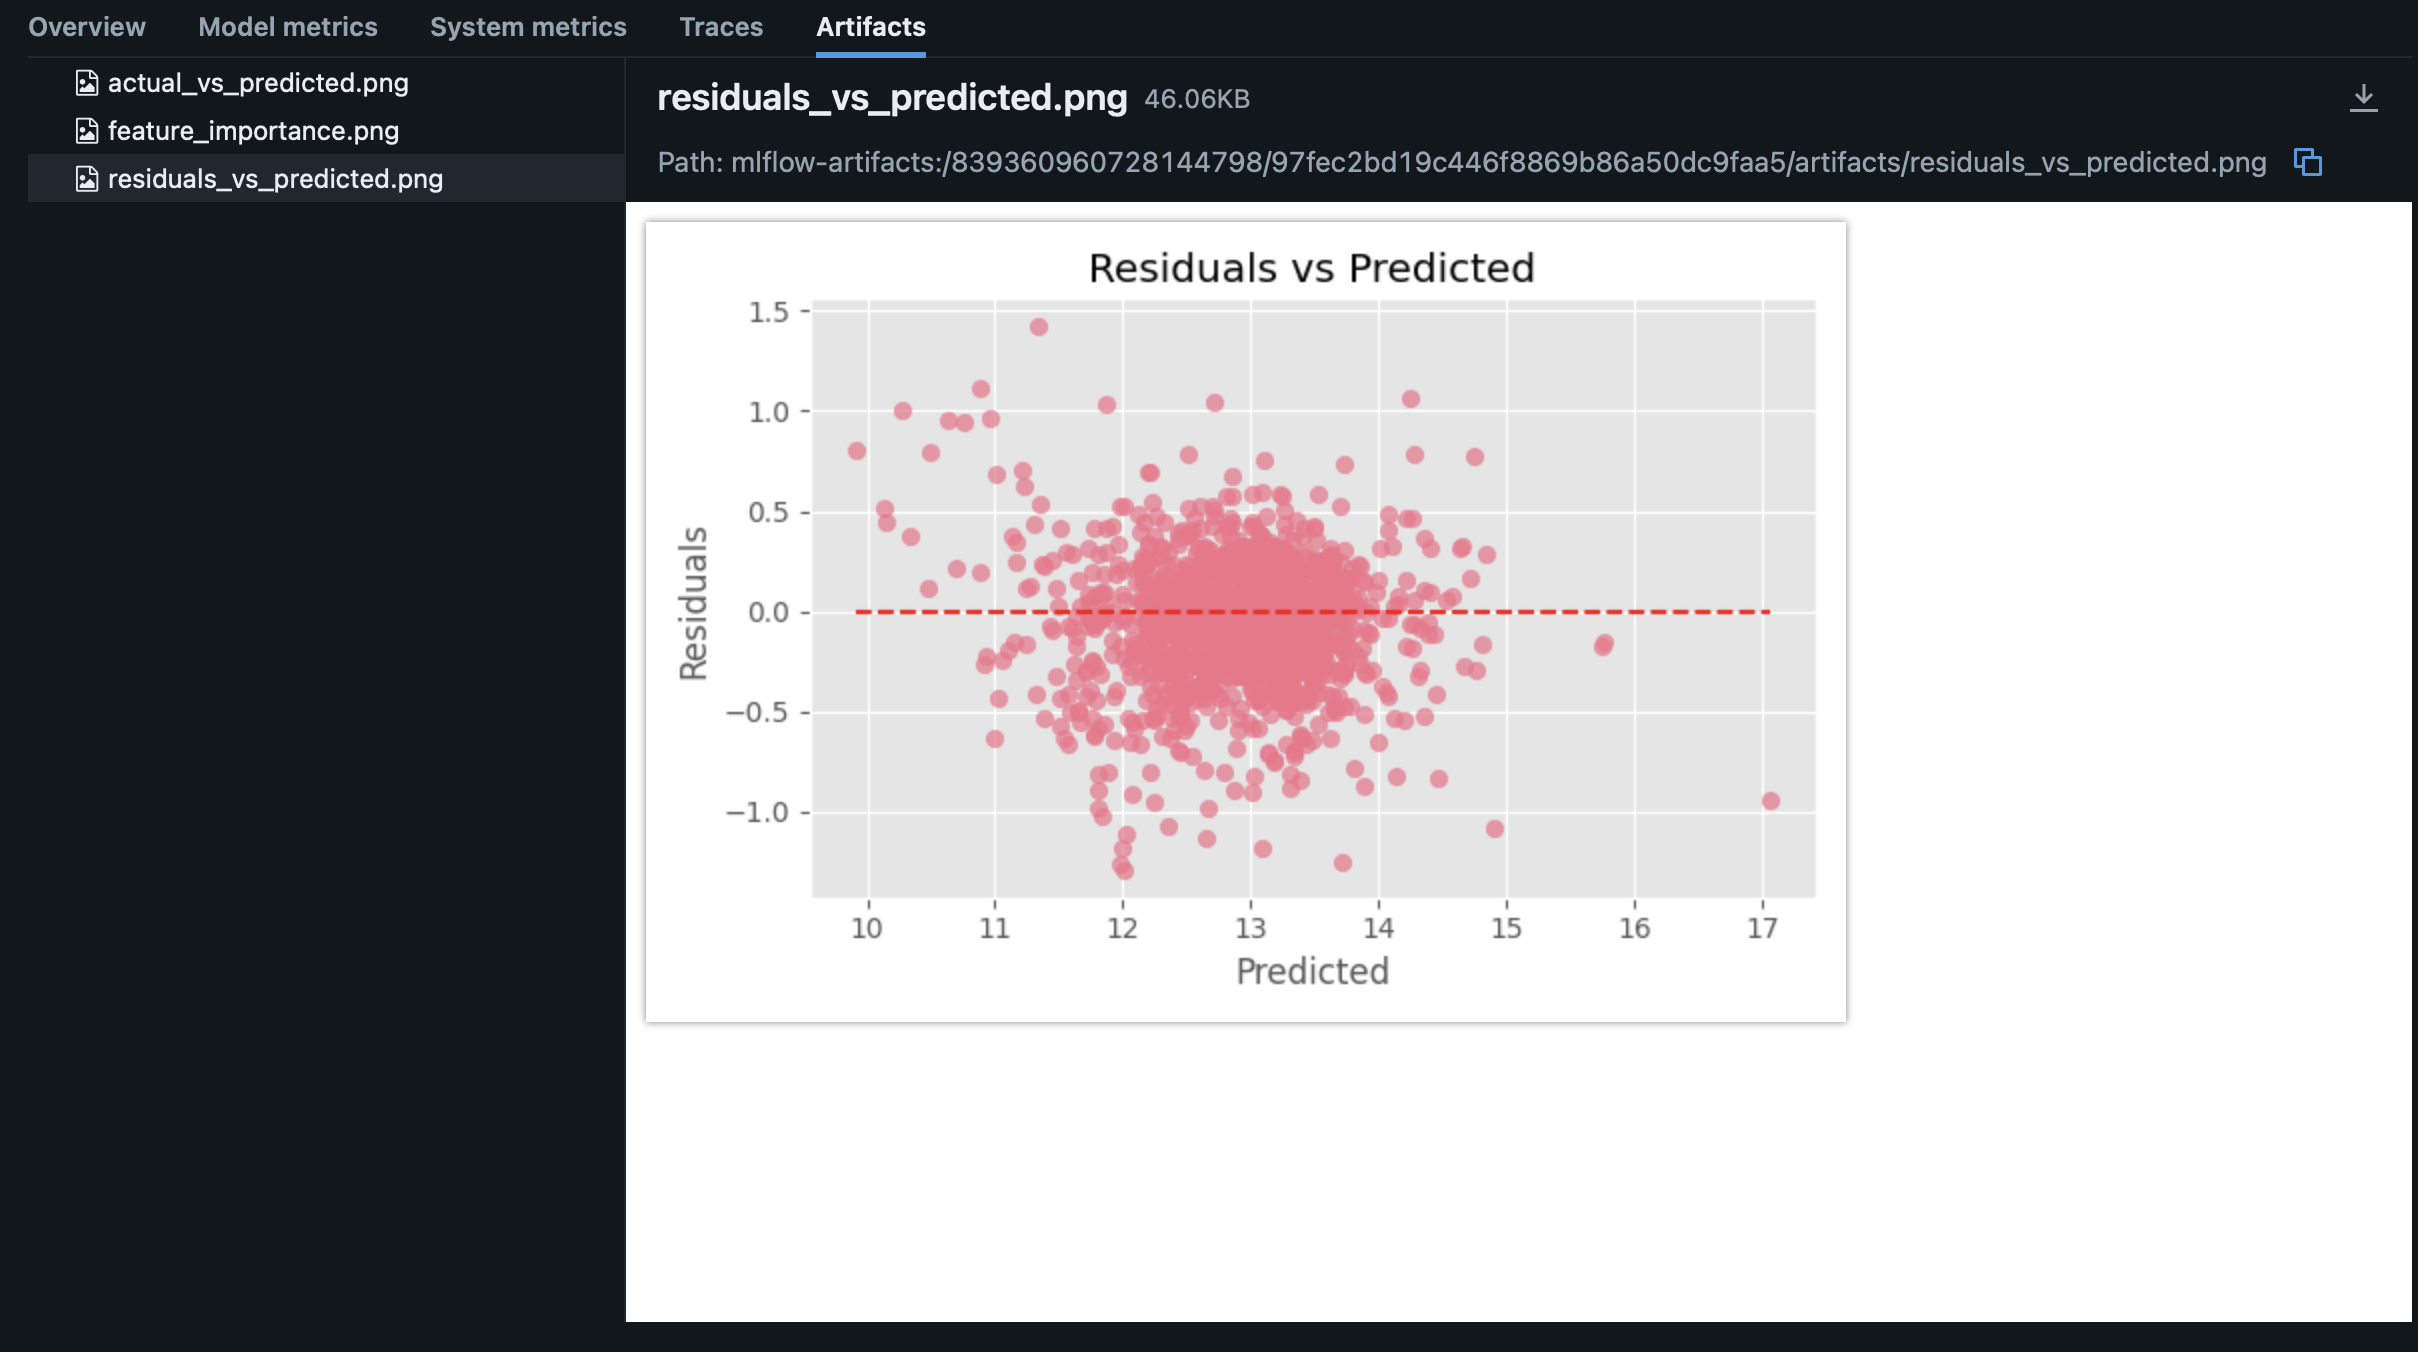
---

## Discussion
- **Best Model Types:** Lasso (R²=0.716) slightly better than Ridge & ElasticNet  
- **Momentum:** (0.713 R²)  
- **Optimization:** Stochastic best (R²= 0.823), Improvement
- **Initialization:** Xavier (0.803) - Zero (0.715)  
- **Learning Rate:** 0.0010 best balance (0.822)  

---

## Conclusion
- Project demonstrated **effective preprocessing, model training, and experiment tracking**.  
- Best-performing config:  
  - **Lasso**, **Stochastic**, **Xavier**, **momentum**, **lr=0.0010**  
- Visuals confirmed key predictors (e.g., max power, engine, brand).  
- Future work: try **ensemble methods** and **higher-degree polynomials** for improvement.  
